 C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_finalll.csv
  C:\Users\DELL\Desktop\project_fire\data\processed\elevation_no_outliers.tif
  C:\Users\DELL\Desktop\project_fire\data\processed\fire_final_north1.csv"
  input_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\landcover_clean.gpkg"
   C:\Users\DELL\Desktop\project_fire\data\processed\climate_seasonal

In [2]:
# ============================================================================
# MERGE CSV + GEOPACKAGE BASÉ SUR LATITUDE/LONGITUDE
# ============================================================================

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Chemins
csv_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_final_north1.csv"
gpkg_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\landcover_essential.gpkg"
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_merged.csv"

print("="*70)
print("MERGE CSV + GEOPACKAGE BASÉ SUR COORDONNÉES")
print("="*70)

# 1. CHARGEMENT DES DONNÉES
print("1. Chargement des données...")

# Charger le CSV
csv_data = pd.read_csv(csv_path)
print(f"   • CSV shape : {csv_data.shape}")
print(f"   • Colonnes CSV : {list(csv_data.columns)}")

# Charger le GeoPackage
gpkg_data = gpd.read_file(gpkg_path)
print(f"   • GPKG shape : {gpkg_data.shape}")
print(f"   • Colonnes GPKG : {list(gpkg_data.columns)}")
print(f"   • CRS GPKG : {gpkg_data.crs}")

# 2. CRÉATION DES GÉOMÉTRIES POUR LE CSV
print("\n2. Création des géométries à partir des coordonnées...")

# Vérifier que les colonnes existent
required_cols = ['longitude', 'latitude']
for col in required_cols:
    if col not in csv_data.columns:
        print(f"   ❌ ERREUR : Colonne '{col}' manquante dans le CSV")
        exit()

# Créer les points géométriques
csv_data['geometry'] = [Point(lon, lat) for lon, lat in zip(csv_data['longitude'], csv_data['latitude'])]

# Convertir en GeoDataFrame
csv_gdf = gpd.GeoDataFrame(csv_data, geometry='geometry', crs='EPSG:4326')
print(f"   • GeoDataFrame créé : {csv_gdf.shape}")
print(f"   • CRS défini : {csv_gdf.crs}")

# 3. VÉRIFICATION DES COORDONNÉES
print("\n3. Vérification des coordonnées...")

print(f"   • Plage longitude : [{csv_gdf['longitude'].min():.4f}, {csv_gdf['longitude'].max():.4f}]")
print(f"   • Plage latitude : [{csv_gdf['latitude'].min():.4f}, {csv_gdf['latitude'].max():.4f}]")

# Vérifier si les coordonnées sont dans des plages réalistes
if csv_gdf['longitude'].min() < -180 or csv_gdf['longitude'].max() > 180:
    print("   ⚠️  Valeurs longitude hors limites WGS84")
if csv_gdf['latitude'].min() < -90 or csv_gdf['latitude'].max() > 90:
    print("   ⚠️  Valeurs latitude hors limites WGS84")

# 4. REPROJECTION SI NÉCESSAIRE
print("\n4. Gestion des systèmes de coordonnées...")

# Vérifier et harmoniser les CRS
if gpkg_data.crs != csv_gdf.crs:
    print(f"   ⚠️  CRS différents :")
    print(f"      • CSV : {csv_gdf.crs}")
    print(f"      • GPKG : {gpkg_data.crs}")
    
    # Essayer de reprojeter le GPKG vers WGS84
    try:
        gpkg_data = gpkg_data.to_crs('EPSG:4326')
        print(f"   ✅ GPKG reprojeté en WGS84 (EPSG:4326)")
    except Exception as e:
        print(f"   ❌ Erreur reprojection : {e}")
        print(f"   → Tentative reprojection CSV vers CRS GPKG...")
        csv_gdf = csv_gdf.to_crs(gpkg_data.crs)
else:
    print(f"   ✅ CRS identiques : {csv_gdf.crs}")

# 5. JOINTURE SPATIALE PRÉCISE
print("\n5. Jointure spatiale...")

# Option 1: WITHIN (point dans polygone)
print("   Tentative jointure 'within'...")
merged = gpd.sjoin(
    csv_gdf,           # Points (feux)
    gpkg_data,         # Polygones (landcover)
    how='left',        # Garder tous les points
    predicate='within' # Point à l'intérieur du polygone
)

match_rate = (1 - merged['index_right'].isna().sum() / len(merged)) * 100
print(f"   • Taux de correspondance : {match_rate:.1f}%")

# 6. ALTERNATIVES SI FAIBLE CORRESPONDANCE
if match_rate < 80:
    print(f"\n   ⚠️  Taux de correspondance faible, essai d'autres méthodes...")
    
    # Option 2: INTERSECTS (point touche le polygone)
    print("   Tentative jointure 'intersects'...")
    merged_intersects = gpd.sjoin(
        csv_gdf,
        gpkg_data,
        how='left',
        predicate='intersects'
    )
    
    match_rate_intersects = (1 - merged_intersects['index_right'].isna().sum() / len(merged_intersects)) * 100
    print(f"   • Taux de correspondance (intersects) : {match_rate_intersects:.1f}%")
    
    if match_rate_intersects > match_rate:
        merged = merged_intersects
        match_rate = match_rate_intersects
    
    # Option 3: NEAREST (point le plus proche)
    if match_rate < 90:
        print("   Tentative jointure 'nearest'...")
        try:
            merged_nearest = gpd.sjoin_nearest(
                csv_gdf,
                gpkg_data,
                how='left',
                max_distance=1000,  # 1km maximum
                distance_col='distance_m'
            )
            
            match_rate_nearest = (1 - merged_nearest['index_right'].isna().sum() / len(merged_nearest)) * 100
            avg_distance = merged_nearest['distance_m'].mean() if 'distance_m' in merged_nearest.columns else 0
            
            print(f"   • Taux de correspondance (nearest) : {match_rate_nearest:.1f}%")
            print(f"   • Distance moyenne : {avg_distance:.1f} m")
            
            if match_rate_nearest > match_rate:
                merged = merged_nearest
        except Exception as e:
            print(f"   ❌ Erreur sjoin_nearest : {e}")

# 7. NETTOYAGE DES RÉSULTATS
print("\n6. Nettoyage des résultats...")

# Colonnes à conserver
base_cols = ['fire', 'longitude', 'latitude']

# Identifier les colonnes landcover (exclure géométrie et index)
landcover_cols = [col for col in gpkg_data.columns if col != 'geometry']
print(f"   • Colonnes landcover disponibles : {len(landcover_cols)}")

# Sélectionner les colonnes finales
final_cols = base_cols.copy()
available_landcover = [col for col in landcover_cols if col in merged.columns]
final_cols.extend(available_landcover)

# Créer le dataset final
final_df = merged[final_cols].copy()

print(f"   • Colonnes finales : {len(final_df.columns)}")

# 8. TRAITEMENT DES VALEURS MANQUANTES
print("\n7. Traitement des valeurs manquantes...")

missing_before = merged['index_right'].isna().sum()
print(f"   • Points sans correspondance landcover : {missing_before} ({missing_before/len(merged)*100:.1f}%)")

if missing_before > 0:
    # Pour les points sans correspondance, on peut :
    # 1. Imputer avec la valeur la plus proche spatialement
    # 2. Utiliser une valeur par défaut
    # 3. Supprimer les points (non recommandé)
    
    print(f"   • Stratégie : Imputation par valeur dominante...")
    
    for col in available_landcover:
        if col in final_df.columns and final_df[col].isna().any():
            # Remplacer NaN par la valeur la plus fréquente
            mode_val = final_df[col].mode()
            if not mode_val.empty:
                final_df[col] = final_df[col].fillna(mode_val.iloc[0])
                print(f"      • {col:20} : NaN → {mode_val.iloc[0]}")

# 9. VÉRIFICATION FINALE
print("\n8. Vérification finale...")

print(f"   • Dataset final shape : {final_df.shape}")
print(f"   • Valeurs manquantes restantes : {final_df.isna().sum().sum()}")

# Vérifier la distribution des classes landcover
if available_landcover:
    sample_col = available_landcover[0]
    print(f"\n   • Distribution de '{sample_col}' :")
    value_counts = final_df[sample_col].value_counts().head()
    for val, count in value_counts.items():
        pct = count / len(final_df) * 100
        print(f"      {val} : {count:8} ({pct:.1f}%)")

# 10. SAUVEGARDE
print("\n9. Sauvegarde...")

final_df.to_csv(output_path, index=False)

print(f"""
✅ MERGE TERMINÉ AVEC SUCCÈS !

📊 RÉSULTATS :
   • CSV initial          : {csv_data.shape}
   • GPKG landcover       : {gpkg_data.shape}
   • Dataset fusionné     : {final_df.shape}
   • Taux correspondance  : {match_rate:.1f}%
   • Fichier de sortie    : {output_path}

🎯 COLONNES AJOUTÉES ({len(available_landcover)}) :
{', '.join(available_landcover)}

📋 ÉCHANTILLON FINAL :
{final_df.head()}
""")

MERGE CSV + GEOPACKAGE BASÉ SUR COORDONNÉES
1. Chargement des données...
   • CSV shape : (1797608, 3)
   • Colonnes CSV : ['fire', 'longitude', 'latitude']
   • GPKG shape : (438513, 3)
   • Colonnes GPKG : ['AREA_M2', 'LCCCODE', 'geometry']
   • CRS GPKG : EPSG:4326

2. Création des géométries à partir des coordonnées...
   • GeoDataFrame créé : (1797608, 4)
   • CRS défini : EPSG:4326

3. Vérification des coordonnées...
   • Plage longitude : [-8.6694, 11.5966]
   • Plage latitude : [28.0060, 37.5406]

4. Gestion des systèmes de coordonnées...
   ✅ CRS identiques : EPSG:4326

5. Jointure spatiale...
   Tentative jointure 'within'...
   • Taux de correspondance : 99.8%

6. Nettoyage des résultats...
   • Colonnes landcover disponibles : 2
   • Colonnes finales : 5

7. Traitement des valeurs manquantes...
   • Points sans correspondance landcover : 3920 (0.2%)
   • Stratégie : Imputation par valeur dominante...
      • AREA_M2              : NaN → 1431818.5100000002
      • LCCCODE   

ANALYSE DU DATASET FUSIONNÉ

1. Distribution des classes feu/non-feu :
   • Non-feu (0) : 1,785,079 (99.30%)
   • Feu (1)     : 12,529 (0.70%)
   • Ratio       : 1:142

2. Analyse de l'occupation du sol (LCCCODE) :
   • Top 10 des codes LCCCODE :
      6001       :  525,070 (29.2%)
      6004       :  494,095 (27.5%)
      0011       :  356,368 (19.8%)
      0004 // 0003 :  101,226 (5.6%)
      20049 // 20058 :   96,989 (5.4%)
      20058      :   77,348 (4.3%)
      0003 / 0004 :   63,342 (3.5%)
      11498      :   28,133 (1.6%)
      21446 // 21450-121340 / 21454 :   16,696 (0.9%)
      21450      :   15,210 (0.8%)

   • Distribution LCCCODE pour les feux :
      6001       : 4,544 feux (36.3% des feux, 29.2% total)
      6004       : 3,165 feux (25.3% des feux, 27.5% total)
      0011       : 1,953 feux (15.6% des feux, 19.8% total)
      0004 // 0003 :   880 feux (7.0% des feux, 5.6% total)
      0003 / 0004 :   567 feux (4.5% des feux, 3.5% total)

3. Analyse des surfaces (AREA_M

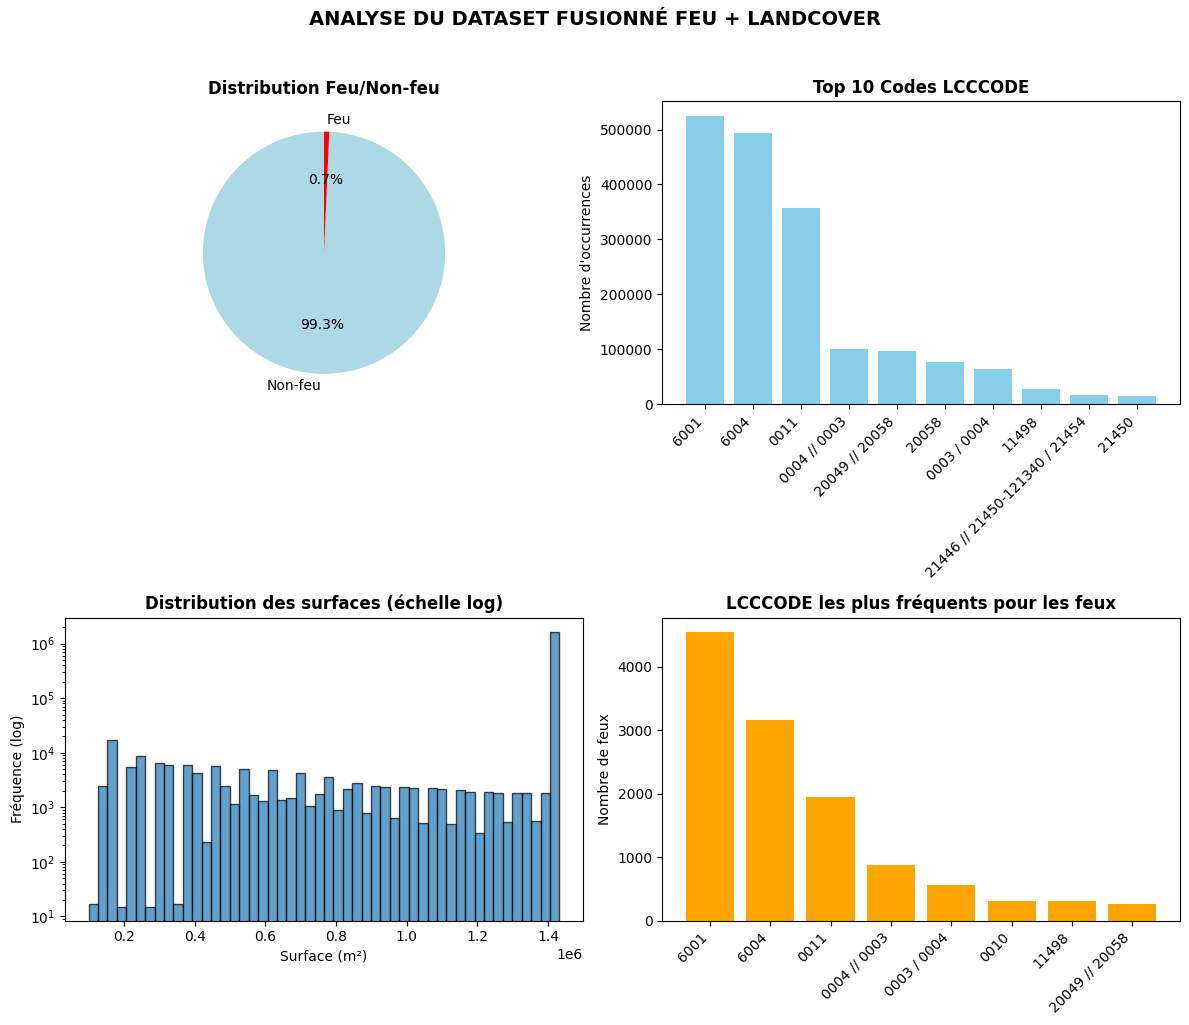


5. Export des statistiques...

   • Top 5 LCCCODE par taux de feu :
      0010       : 312.0 feux sur 5959.0 obs (5.24%)
      21499-121340 : 17.0 feux sur  855.0 obs (1.99%)
      21450      : 190.0 feux sur 15210.0 obs (1.25%)
      21518      : 50.0 feux sur 4292.0 obs (1.16%)
      21497-121340 : 66.0 feux sur 5918.0 obs (1.12%)
      11498      : 307.0 feux sur 28133.0 obs (1.09%)
   ✅ Statistiques sauvegardées : C:\Users\DELL\Desktop\project_fire\reports\landcover_fire_stats.csv

ANALYSE TERMINÉE


In [3]:
# ============================================================================
# ANALYSE DES RÉSULTATS DU MERGE
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# Charger le dataset fusionné
merged_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_merged.csv"
df = pd.read_csv(merged_path)

print("="*70)
print("ANALYSE DU DATASET FUSIONNÉ")
print("="*70)

# 1. DISTRIBUTION DES CLASSES
print("\n1. Distribution des classes feu/non-feu :")
fire_counts = df['fire'].value_counts()
fire_pct = df['fire'].value_counts(normalize=True) * 100

print(f"   • Non-feu (0) : {fire_counts[0]:,} ({fire_pct[0]:.2f}%)")
print(f"   • Feu (1)     : {fire_counts[1]:,} ({fire_pct[1]:.2f}%)")
print(f"   • Ratio       : 1:{fire_counts[0]/fire_counts[1]:.0f}")

# 2. ANALYSE LANDCOVER PAR CLASSE
print("\n2. Analyse de l'occupation du sol (LCCCODE) :")

# Top 10 des codes LCCCODE les plus fréquents
print(f"   • Top 10 des codes LCCCODE :")
top_lcc = df['LCCCODE'].value_counts().head(10)
for code, count in top_lcc.items():
    pct = count / len(df) * 100
    print(f"      {code:10} : {count:8,} ({pct:.1f}%)")

# Distribution LCCCODE par classe feu/non-feu
print(f"\n   • Distribution LCCCODE pour les feux :")
fire_lcc = df[df['fire'] == 1]['LCCCODE'].value_counts().head(5)
for code, count in fire_lcc.items():
    pct_fire = count / fire_counts[1] * 100
    pct_total = (df['LCCCODE'] == code).sum() / len(df) * 100
    print(f"      {code:10} : {count:5,} feux ({pct_fire:.1f}% des feux, {pct_total:.1f}% total)")

# 3. ANALYSE DES SURFACES
print("\n3. Analyse des surfaces (AREA_M2) :")

print(f"   • Statistiques descriptives :")
print(f"      Min      : {df['AREA_M2'].min():,.0f} m²")
print(f"      Max      : {df['AREA_M2'].max():,.0f} m²")
print(f"      Moyenne  : {df['AREA_M2'].mean():,.0f} m²")
print(f"      Médiane  : {df['AREA_M2'].median():,.0f} m²")

# Comparaison surfaces feu vs non-feu
print(f"\n   • Comparaison surfaces feu vs non-feu :")
area_fire = df[df['fire'] == 1]['AREA_M2'].describe()
area_nofire = df[df['fire'] == 0]['AREA_M2'].describe()

print(f"      Surface moyenne - Feu     : {area_fire['mean']:,.0f} m²")
print(f"      Surface moyenne - Non-feu : {area_nofire['mean']:,.0f} m²")
print(f"      Ratio                     : {area_fire['mean']/area_nofire['mean']:.2f}")

# 4. VISUALISATION
print("\n4. Visualisations...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 4.1 Distribution des feux
axes[0, 0].pie(fire_counts, labels=['Non-feu', 'Feu'], autopct='%1.1f%%', 
               colors=['lightblue', 'red'], startangle=90)
axes[0, 0].set_title('Distribution Feu/Non-feu', fontweight='bold')

# 4.2 Top 10 LCCCODE
top10 = df['LCCCODE'].value_counts().head(10)
axes[0, 1].bar(range(len(top10)), top10.values, color='skyblue')
axes[0, 1].set_xticks(range(len(top10)))
axes[0, 1].set_xticklabels(top10.index, rotation=45, ha='right')
axes[0, 1].set_title('Top 10 Codes LCCCODE', fontweight='bold')
axes[0, 1].set_ylabel('Nombre d\'occurrences')

# 4.3 Distribution AREA_M2 (log scale)
axes[1, 0].hist(df['AREA_M2'], bins=50, edgecolor='black', alpha=0.7, log=True)
axes[1, 0].set_title('Distribution des surfaces (échelle log)', fontweight='bold')
axes[1, 0].set_xlabel('Surface (m²)')
axes[1, 0].set_ylabel('Fréquence (log)')

# 4.4 LCCCODE pour les feux uniquement
fire_lcc_top = df[df['fire'] == 1]['LCCCODE'].value_counts().head(8)
axes[1, 1].bar(range(len(fire_lcc_top)), fire_lcc_top.values, color='orange')
axes[1, 1].set_xticks(range(len(fire_lcc_top)))
axes[1, 1].set_xticklabels(fire_lcc_top.index, rotation=45, ha='right')
axes[1, 1].set_title('LCCCODE les plus fréquents pour les feux', fontweight='bold')
axes[1, 1].set_ylabel('Nombre de feux')

plt.suptitle('ANALYSE DU DATASET FUSIONNÉ FEU + LANDCOVER', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Sauvegarder
output_fig = r"C:\Users\DELL\Desktop\project_fire\reports\figures\fire_landcover_analysis.png"
plt.savefig(output_fig, dpi=300, bbox_inches='tight')
print(f"   ✅ Figure sauvegardée : {output_fig}")
plt.show()

# 5. EXPORT DES STATISTIQUES
print("\n5. Export des statistiques...")

# Tableau de contingence LCCCODE vs Feu
contingency = pd.crosstab(df['LCCCODE'], df['fire'], margins=True)
contingency['pct_fire'] = (contingency[1] / contingency['All']) * 100
contingency['pct_total'] = (contingency['All'] / contingency.loc['All', 'All']) * 100

# Trier par pourcentage de feu
contingency_sorted = contingency.sort_values('pct_fire', ascending=False)

print(f"\n   • Top 5 LCCCODE par taux de feu :")
for idx, row in contingency_sorted.head(6).iterrows():
    if idx != 'All':
        print(f"      {idx:10} : {row[1]:4} feux sur {row['All']:6} obs ({row['pct_fire']:.2f}%)")

# Sauvegarder le tableau
stats_path = r"C:\Users\DELL\Desktop\project_fire\reports\landcover_fire_stats.csv"
contingency_sorted.to_csv(stats_path)
print(f"   ✅ Statistiques sauvegardées : {stats_path}")

print("\n" + "="*70)
print("ANALYSE TERMINÉE")
print("="*70)

In [5]:
import pandas as pd

df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_merged.csv")

print("="*60)
print("10 PREMIÈRES LIGNES")
print("="*60)
print(df.head(10))
print("\nDimensions:", df.shape)

10 PREMIÈRES LIGNES
   fire  longitude  latitude     AREA_M2 LCCCODE
0     1    5.53337  35.70751   309903.24   21518
1     1    6.46961  32.13579  1431818.51    6004
2     1    6.97630  32.35563  1431818.51    6004
3     1    9.39581  28.19791  1431818.51    6001
4     1    9.49323  28.12826  1431818.51    6001
5     1    7.02693  30.47348  1431818.51    6004
6     1    7.02260  30.47437  1431818.51    6004
7     1    6.78554  31.18760  1431818.51    6001
8     1    6.05296  31.35859  1431818.51    6001
9     1    6.04889  31.36055  1431818.51    6001

Dimensions: (1797608, 5)


In [1]:
# ============================================================================
# SCRIPT COMPLET - FUSION FIRE + LANDCOVER + ÉLÉVATION
# ============================================================================

import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
import os
from tqdm import tqdm  # Pour la barre de progression

# ============================================================================
# CONFIGURATION - MODIFIEZ CES CHEMINS SELON VOTRE ENVIRONNEMENT
# ============================================================================

# Chemins d'entrée
input_csv = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_merged.csv"
input_raster = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_no_outliers.tif"

# Chemin de sortie
output_csv = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_elevation_final.csv"

# ============================================================================
# VÉRIFICATION DES FICHIERS
# ============================================================================

print("🔍 Vérification des fichiers...")

# Vérifier si les fichiers existent
if not os.path.exists(input_csv):
    print(f"❌ ERREUR: Fichier CSV introuvable: {input_csv}")
    print("   Vérifiez le chemin et réessayez.")
    exit()

if not os.path.exists(input_raster):
    print(f"❌ ERREUR: Fichier raster introuvable: {input_raster}")
    print("   Vérifiez le chemin et réessayez.")
    exit()

print(f"✅ CSV trouvé: {input_csv}")
print(f"✅ Raster trouvé: {input_raster}")

# ============================================================================
# FONCTION POUR TRAITER PAR CHUNKS (OPTIMISÉ POUR GRAND DATASET)
# ============================================================================

def process_with_chunks(csv_path, raster_path, output_path, chunk_size=200000):
    """
    Traite un grand CSV par chunks pour économiser la mémoire
    """
    print(f"\n⚡ Début du traitement avec chunks de {chunk_size:,} lignes")
    
    # Ouvrir le raster une seule fois
    with rasterio.open(raster_path) as raster:
        print(f"📊 Informations raster:")
        print(f"   CRS: {raster.crs}")
        print(f"   Dimensions: {raster.shape}")
        print(f"   Type de données: {raster.dtypes[0]}")
        
        # Liste pour stocker tous les chunks traités
        all_chunks = []
        
        # Lire le CSV par chunks
        total_rows = 0
        for chunk_idx, chunk_df in enumerate(pd.read_csv(csv_path, chunksize=chunk_size)):
            total_rows += len(chunk_df)
            print(f"\n📁 Chunk {chunk_idx + 1}: {len(chunk_df):,} lignes")
            
            # 1. Créer GeoDataFrame
            chunk_gdf = gpd.GeoDataFrame(
                chunk_df,
                geometry=gpd.points_from_xy(chunk_df.longitude, chunk_df.latitude),
                crs="EPSG:4326"
            )
            
            # 2. Reprojection si nécessaire
            if chunk_gdf.crs != raster.crs:
                print(f"   🔄 Reprojection vers {raster.crs}...")
                chunk_gdf = chunk_gdf.to_crs(raster.crs)
            
            # 3. Préparer les coordonnées pour l'échantillonnage
            print("   📍 Extraction des élévations...")
            coords = [(x, y) for x, y in zip(chunk_gdf.geometry.x, chunk_gdf.geometry.y)]
            
            # 4. Extraire les valeurs d'élévation
            sampled_values = list(raster.sample(coords))
            
            # 5. Convertir et filtrer les élévations
            elevations = []
            for val in sampled_values:
                if val is not None and len(val) > 0:
                    elev_val = float(val[0])
                    # Filtrer les valeurs aberrantes
                    if -1000 < elev_val < 10000:
                        elevations.append(elev_val)
                    else:
                        elevations.append(np.nan)
                else:
                    elevations.append(np.nan)
            
            # 6. Ajouter la colonne d'élévation
            chunk_gdf['elevation'] = elevations
            
            # 7. Retourner aux coordonnées géographiques (WGS84)
            if chunk_gdf.crs != "EPSG:4326":
                chunk_gdf = chunk_gdf.to_crs("EPSG:4326")
            
            # 8. Mettre à jour les colonnes de coordonnées
            chunk_gdf['longitude'] = chunk_gdf.geometry.x
            chunk_gdf['latitude'] = chunk_gdf.geometry.y
            
            # 9. Supprimer la géométrie si elle n'est plus nécessaire
            chunk_df_result = pd.DataFrame(chunk_gdf.drop(columns=['geometry']))
            
            # 10. Ajouter à la liste des résultats
            all_chunks.append(chunk_df_result)
            
            # Nettoyer la mémoire
            del chunk_gdf, chunk_df, elevations, sampled_values
            import gc
            gc.collect()
            
            print(f"   ✅ Chunk {chunk_idx + 1} terminé")
    
    print(f"\n📈 Total des lignes traitées: {total_rows:,}")
    
    # Combiner tous les chunks
    print("🔗 Combinaison de tous les chunks...")
    final_df = pd.concat(all_chunks, ignore_index=True)
    
    # Imputer les valeurs manquantes globalement
    missing_values = final_df['elevation'].isna().sum()
    if missing_values > 0:
        print(f"🔧 Imputation de {missing_values:,} valeurs manquantes...")
        median_elev = final_df['elevation'].median(skipna=True)
        final_df['elevation'] = final_df['elevation'].fillna(median_elev)
        print(f"   Médiane utilisée: {median_elev:.1f}m")
    
    return final_df

# ============================================================================
# EXÉCUTION PRINCIPALE
# ============================================================================

try:
    # Option 1: Essayer de charger en une fois (si la mémoire le permet)
    print("\n🔄 Tentative de chargement direct...")
    try:
        # Charger les données
        fire_lc = pd.read_csv(input_csv)
        print(f"✅ CSV chargé directement: {fire_lc.shape}")
        
        # Créer GeoDataFrame
        fire_gdf = gpd.GeoDataFrame(
            fire_lc,
            geometry=gpd.points_from_xy(fire_lc.longitude, fire_lc.latitude),
            crs="EPSG:4326"
        )
        
        # Ouvrir le raster
        with rasterio.open(input_raster) as raster:
            # Reprojection si nécessaire
            if fire_gdf.crs != raster.crs:
                fire_gdf = fire_gdf.to_crs(raster.crs)
            
            # Extraire les élévations
            coords = [(x, y) for x, y in zip(fire_gdf.geometry.x, fire_gdf.geometry.y)]
            print("📍 Extraction des élévations...")
            
            # Utiliser tqdm pour la barre de progression
            elevations = []
            for val in tqdm(raster.sample(coords), total=len(fire_gdf), desc="Extraction"):
                if val is not None and len(val) > 0:
                    elev_val = float(val[0])
                    if -1000 < elev_val < 10000:
                        elevations.append(elev_val)
                    else:
                        elevations.append(np.nan)
                else:
                    elevations.append(np.nan)
            
            fire_gdf['elevation'] = elevations
            
            # Retour à WGS84
            if fire_gdf.crs != "EPSG:4326":
                fire_gdf = fire_gdf.to_crs("EPSG:4326")
            
            final_df = pd.DataFrame(fire_gdf.drop(columns=['geometry']))
            
    except MemoryError:
        print("⚠️ Mémoire insuffisante, passage au mode chunks...")
        # Option 2: Utiliser le traitement par chunks
        final_df = process_with_chunks(input_csv, input_raster, output_csv)
    
    # Statistiques finales
    print("\n📊 STATISTIQUES FINALES:")
    print(f"   Nombre total de points: {len(final_df):,}")
    print(f"   Élévation min: {final_df['elevation'].min():.1f}m")
    print(f"   Élévation max: {final_df['elevation'].max():.1f}m")
    print(f"   Élévation moyenne: {final_df['elevation'].mean():.1f}m")
    print(f"   Valeurs manquantes: {final_df['elevation'].isna().sum():,}")
    
    # Sauvegarder le résultat
    print(f"\n💾 Sauvegarde vers: {output_csv}")
    final_df.to_csv(output_csv, index=False)
    
    print("\n✅ TRAITEMENT TERMINÉ AVEC SUCCÈS!")
    print(f"📁 Fichier créé: {output_csv}")
    print(f"📐 Taille: {len(final_df):,} lignes × {len(final_df.columns)} colonnes")
    
    # Aperçu des colonnes
    print("\n📋 Colonnes disponibles:")
    for col in final_df.columns:
        print(f"   • {col}")

except Exception as e:
    print(f"\n❌ ERREUR: {str(e)}")
    print("\n🔧 Conseils de dépannage:")
    print("   1. Vérifiez que les chemins sont corrects")
    print("   2. Vérifiez l'espace disque disponible")
    print("   3. Essayez de réduire chunk_size dans process_with_chunks()")
    print("   4. Fermez d'autres applications pour libérer de la RAM")

🔍 Vérification des fichiers...
✅ CSV trouvé: C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_merged.csv
✅ Raster trouvé: C:\Users\DELL\Desktop\project_fire\data\processed\elevation_no_outliers.tif

🔄 Tentative de chargement direct...
✅ CSV chargé directement: (1797608, 5)
📍 Extraction des élévations...


Extraction: 100%|██████████| 1797608/1797608 [01:21<00:00, 22019.39it/s]



📊 STATISTIQUES FINALES:
   Nombre total de points: 1,797,608
   Élévation min: 259.0m
   Élévation max: 679.0m
   Élévation moyenne: 464.4m
   Valeurs manquantes: 0

💾 Sauvegarde vers: C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_elevation_final.csv

✅ TRAITEMENT TERMINÉ AVEC SUCCÈS!
📁 Fichier créé: C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_elevation_final.csv
📐 Taille: 1,797,608 lignes × 6 colonnes

📋 Colonnes disponibles:
   • fire
   • longitude
   • latitude
   • AREA_M2
   • LCCCODE
   • elevation


In [3]:
import pandas as pd

df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_elevation_final.csv")

print("="*60)
print("10 PREMIÈRES LIGNES")
print("="*60)
print(df.head(10))
print("\nDimensions:", df.shape)

print("\n" + "="*60)
print("INFORMATIONS SUR LES COLONNES")
print("="*60)
print(df.info())

print("\n" + "="*60)
print("STATISTIQUES DESCRIPTIVES")
print("="*60)
print(df.describe())

print("\n" + "="*60)
print("VALEURS MANQUANTES")
print("="*60)
print(df.isnull().sum())

10 PREMIÈRES LIGNES
   fire  longitude  latitude     AREA_M2 LCCCODE  elevation
0     1    5.53337  35.70751   309903.24   21518      679.0
1     1    6.46961  32.13579  1431818.51    6004      259.0
2     1    6.97630  32.35563  1431818.51    6004      259.0
3     1    9.39581  28.19791  1431818.51    6001      616.0
4     1    9.49323  28.12826  1431818.51    6001      589.0
5     1    7.02693  30.47348  1431818.51    6004      259.0
6     1    7.02260  30.47437  1431818.51    6004      259.0
7     1    6.78554  31.18760  1431818.51    6001      259.0
8     1    6.05296  31.35859  1431818.51    6001      259.0
9     1    6.04889  31.36055  1431818.51    6001      259.0

Dimensions: (1797608, 6)

INFORMATIONS SUR LES COLONNES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797608 entries, 0 to 1797607
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   fire       int64  
 1   longitude  float64
 2   latitude   float64
 3   AREA_M2    float64
 4   LC

In [2]:
import pandas as pd
import numpy as np
import rasterio
import os

# Chemins
df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_landcover_elevation_final.csv")
climate_dir = r"C:\Users\DELL\Desktop\project_fire\data\processed\climate_seasonal"

print(f"📂 Chargement: {len(df):,} points")

# Extraire chaque variable climatique
for f in os.listdir(climate_dir):
    if f.endswith('.tif'):
        var = f.replace('clean_', '').replace('.tif', '')
        print(f"🌤️  {var}...", end=" ")
        
        try:
            with rasterio.open(os.path.join(climate_dir, f)) as src:
                # Convertir coordonnées → indices
                cols, rows = ~src.transform * (df['longitude'].values, df['latitude'].values)
                cols, rows = cols.astype(int), rows.astype(int)
                
                # Lire les données du raster
                data = src.read(1)
                
                # Extraire les valeurs
                values = np.full(len(df), np.nan, dtype=np.float32)
                
                # Masque des indices valides
                valid_mask = (
                    (rows >= 0) & (rows < data.shape[0]) &
                    (cols >= 0) & (cols < data.shape[1])
                )
                
                if np.any(valid_mask):
                    values[valid_mask] = data[rows[valid_mask], cols[valid_mask]]
                
                # Imputer avec la moyenne des valeurs valides
                mean_val = np.nanmean(values)
                values = np.where(np.isnan(values), mean_val, values)
                
                # Ajouter au DataFrame
                df[var] = values
                
                # Afficher statistiques
                valid_count = np.sum(~np.isnan(values))
                print(f"✓ ({mean_val:.1f})")
                
        except Exception as e:
            print(f"✗ Erreur: {str(e)[:50]}...")
            df[var] = np.nan

# Sauvegarder
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv"
df.to_csv(output_path, index=False)

print(f"""
✅ MERGE TERMINÉ !

📊 Résultat :
• Fichier : {output_path}
• Points  : {len(df):,}
• Colonnes : {len(df.columns)}
• Variables climatiques : {sum(1 for col in df.columns if any(x in col for x in ['prec', 'tmax', 'tmin']))}
""")

# Afficher les premières lignes
print("\n🔍 Aperçu des nouvelles colonnes :")
climate_cols = [col for col in df.columns if any(x in col for x in ['prec', 'tmax', 'tmin'])]
print(df[['latitude', 'longitude'] + climate_cols[:3]].head())

📂 Chargement: 1,797,608 points
🌤️  prec_DJF... ✓ (35.5)
🌤️  prec_JJA... ✓ (7.7)
🌤️  prec_MAM... ✓ (24.4)
🌤️  prec_SON... ✓ (34.7)
🌤️  tmax_DJF... ✓ (18.7)
🌤️  tmax_JJA... ✓ (40.2)
🌤️  tmax_MAM... ✓ (28.6)
🌤️  tmax_SON... ✓ (29.7)
🌤️  tmin_DJF... ✓ (5.7)
🌤️  tmin_JJA... ✓ (25.0)
🌤️  tmin_MAM... ✓ (14.3)
🌤️  tmin_SON... ✓ (16.7)

✅ MERGE TERMINÉ !

📊 Résultat :
• Fichier : C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv
• Points  : 1,797,608
• Colonnes : 18
• Variables climatiques : 12


🔍 Aperçu des nouvelles colonnes :
   latitude  longitude    prec_DJF   prec_JJA   prec_MAM
0  35.70751    5.53337  115.025002  19.674999  60.275002
1  32.13579    6.46961    9.475000   2.300000  16.900002
2  32.35563    6.97630   10.425000   2.200000  21.075001
3  28.19791    9.39581    8.950000   1.000000  10.225000
4  28.12826    9.49323    8.200000   1.000000  10.200000


In [4]:
import pandas as pd

df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv")

print("="*60)
print("10 PREMIÈRES LIGNES")
print("="*60)
print(df.head(10))
print("\nDimensions:", df.shape)

print("\n" + "="*60)
print("INFORMATIONS SUR LES COLONNES")
print("="*60)
print(df.info())

print("\n" + "="*60)
print("STATISTIQUES DESCRIPTIVES")
print("="*60)
print(df.describe())

print("\n" + "="*60)
print("VALEURS MANQUANTES")
print("="*60)
print(df.isnull().sum())

C:\Users\DELL\AppData\Local\Temp\ipykernel_10432\2618088766.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv")


10 PREMIÈRES LIGNES
   fire  longitude  latitude     AREA_M2 LCCCODE  elevation    prec_DJF  \
0     1    5.53337  35.70751   309903.24   21518      679.0  115.025000   
1     1    6.46961  32.13579  1431818.51    6004      259.0    9.475000   
2     1    6.97630  32.35563  1431818.51    6004      259.0   10.425000   
3     1    9.39581  28.19791  1431818.51    6001      616.0    8.950000   
4     1    9.49323  28.12826  1431818.51    6001      589.0    8.200000   
5     1    7.02693  30.47348  1431818.51    6004      259.0   10.000000   
6     1    7.02260  30.47437  1431818.51    6004      259.0   10.000000   
7     1    6.78554  31.18760  1431818.51    6001      259.0   10.424999   
8     1    6.05296  31.35859  1431818.51    6001      259.0    8.325000   
9     1    6.04889  31.36055  1431818.51    6001      259.0    8.325000   

   prec_JJA   prec_MAM    prec_SON   tmax_DJF   tmax_JJA   tmax_MAM  \
0    19.675  60.275000  106.825000   8.833333  29.666666  17.166666   
1     2.300 

In [4]:
import pandas as pd

# Charger les 10 premières lignes
file_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv"
df = pd.read_csv(file_path, nrows=10)

print("="*80)
print("📊 10 PREMIÈRES LIGNES DU DATASET")
print("="*80)

# Afficher sous forme de tableau propre
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
pd.set_option('display.width', 120)         # Largeur d'affichage
pd.set_option('display.max_colwidth', 15)   # Largeur max par colonne

print(df.to_string(index=False))  # Sans index

print("\n" + "="*80)
print("📈 RÉSUMÉ")
print("="*80)
print(f"• Forme : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"• Colonnes : {list(df.columns[:5])}...")
print(f"• Types : {df.dtypes.value_counts().to_dict()}")

📊 10 PREMIÈRES LIGNES DU DATASET
 fire  longitude  latitude    AREA_M2  LCCCODE  elevation   prec_DJF  prec_JJA  prec_MAM   prec_SON  tmax_DJF  tmax_JJA  tmax_MAM  tmax_SON  tmin_DJF  tmin_JJA  tmin_MAM  tmin_SON
    1    5.53337  35.70751  309903.24    21518      679.0 115.025000    19.675 60.275000 106.825000  8.833333 29.666666 17.166666 19.416666  1.250000 16.250000  6.500000 10.000000
    1    6.46961  32.13579 1431818.51     6004      259.0   9.475000     2.300 16.900002  16.850000 19.750000 43.666668 31.666666 32.250000  6.666666 28.666666 16.916666 19.333334
    1    6.97630  32.35563 1431818.51     6004      259.0  10.425000     2.200 21.075000  16.675001 19.666666 43.333332 31.333334 32.000000  6.500000 28.333334 16.666666 19.250000
    1    9.39581  28.19791 1431818.51     6001      616.0   8.950000     1.000 10.225000   4.475000 19.916666 41.333332 31.500000 31.666666  4.083334 25.000000 15.083333 16.666666
    1    9.49323  28.12826 1431818.51     6001      589.0   8.20000

In [5]:
import pandas as pd

# Charger vos données
df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv")

# Afficher toutes les colonnes
print("="*60)
print("📋 TOUTES LES COLONNES :")
print("="*60)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2}. {col}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_10432\2687747116.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv")


📋 TOUTES LES COLONNES :
 1. fire
 2. longitude
 3. latitude
 4. AREA_M2
 5. LCCCODE
 6. elevation
 7. prec_DJF
 8. prec_JJA
 9. prec_MAM
10. prec_SON
11. tmax_DJF
12. tmax_JJA
13. tmax_MAM
14. tmax_SON
15. tmin_DJF
16. tmin_JJA
17. tmin_MAM
18. tmin_SON


In [28]:
import pandas as pd

# Charger ton fichier
df = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv")

# Afficher le total de valeurs manquantes par colonne
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

# Afficher le pourcentage de valeurs manquantes
print("\nPourcentage de valeurs manquantes :")
print((df.isnull().mean() * 100).round(2))


Valeurs manquantes par colonne :
HWSD2_SMU_ID     0
COARSE           0
SAND             0
SILT             0
CLAY             0
TEXTURE_USDA     0
TEXTURE_SOTER    0
BULK             0
REF_BULK         0
ORG_CARBON       0
PH_WATER         0
TOTAL_N          0
CN_RATIO         0
CEC_SOIL         0
CEC_CLAY         0
CEC_EFF          0
TEB              0
BSAT             0
ALUM_SAT         0
ESP              0
TCARBON_EQ       0
GYPSUM           0
ELEC_COND        0
TEXTURE_-        0
TEXTURE_C        0
TEXTURE_F        0
TEXTURE_M        0
dtype: int64

Pourcentage de valeurs manquantes :
HWSD2_SMU_ID     0.0
COARSE           0.0
SAND             0.0
SILT             0.0
CLAY             0.0
TEXTURE_USDA     0.0
TEXTURE_SOTER    0.0
BULK             0.0
REF_BULK         0.0
ORG_CARBON       0.0
PH_WATER         0.0
TOTAL_N          0.0
CN_RATIO         0.0
CEC_SOIL         0.0
CEC_CLAY         0.0
CEC_EFF          0.0
TEB              0.0
BSAT             0.0
ALUM_SAT         0.0
ESP  

In [29]:
import pandas as pd
import rasterio
from rasterio.windows import Window
import numpy as np
import os

# === 1) Charger IDs du sol ===
soil_csv = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv"
soil_df = pd.read_csv(soil_csv)
soil_ids = set(soil_df['HWSD2_SMU_ID'].astype(int))

# === 2) Fichiers raster et output ===
raster_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\HWSD2_cropped.tif"
output_csv = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_with_coords.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

# === 3) Taille du bloc (window) ===
block_size = 1024  # Ajustable selon RAM

with rasterio.open(raster_path) as src, open(output_csv, 'w') as f_out:
    
    f_out.write("HWSD2_SMU_ID,longitude,latitude\n")  # Header CSV

    height, width = src.height, src.width
    transform = src.transform
    nodata = src.nodata

    processed = 0
    
    # Parcours en blocs
    for row in range(0, height, block_size):
        for col in range(0, width, block_size):

            # définir la fenêtre
            win = Window(col_off=col, row_off=row,
                         width=min(block_size, width - col),
                         height=min(block_size, height - row))
            
            # Lire le bloc
            data = src.read(1, window=win)
            
            # Masquer nodata
            if nodata is not None:
                mask = (data != nodata)
            else:
                mask = np.ones_like(data, dtype=bool)

            # Filtrer pixels dont la valeur ∉ soil_ids
            valid = np.vectorize(lambda x: x in soil_ids)(data)
            mask = mask & valid

            # Si aucun pixel valide dans le bloc
            if not np.any(mask):
                continue
            
            # Coordonnées des pixels valides (vectorisé)
            rows, cols = np.where(mask)
            vals = data[rows, cols].astype(int)
            xs, ys = rasterio.transform.xy(
                transform,
                rows + row,  # pos globale
                cols + col,
                offset='center'
            )
            
            # Écriture dans le fichier
            for v, x, y in zip(vals, xs, ys):
                f_out.write(f"{v},{x},{y}\n")

            processed += len(vals)
            print(f"✔ {processed} pixels sauvegardés...")
    
    print(f"\n🎉 Extraction terminée ! Résultat enregistré dans : {output_csv}")


✔ 287686 pixels sauvegardés...
✔ 1234012 pixels sauvegardés...
✔ 1485133 pixels sauvegardés...
✔ 2013100 pixels sauvegardés...
✔ 3030626 pixels sauvegardés...
✔ 3225768 pixels sauvegardés...
✔ 3291515 pixels sauvegardés...

🎉 Extraction terminée ! Résultat enregistré dans : C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_with_coords.csv


In [30]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

fire_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv"
soil_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_with_coords.csv"
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_mergedF.csv"

# --- Charger soil par chunks et réduire la mémoire ---
soil_chunks = []
chunksize = 100000

for chunk in pd.read_csv(soil_path, chunksize=chunksize,
                         dtype={'longitude': 'float32', 'latitude': 'float32'}):
    soil_chunks.append(chunk)

# Concaténer tous les chunks pour créer KDTree
soil_df = pd.concat(soil_chunks, ignore_index=True)
soil_coords = soil_df[['longitude', 'latitude']].to_numpy()
soil_tree = cKDTree(soil_coords)

# --- Lire fire par chunks et traiter par morceaux ---
chunksize_fire = 100000
chunks_merged = []

for chunk in pd.read_csv(fire_path, chunksize=chunksize_fire,
                         dtype={'longitude': 'float32', 'latitude': 'float32'}):
    fire_coords = chunk[['longitude', 'latitude']].to_numpy()
    distances, indices = soil_tree.query(fire_coords, k=1)

    nearest_soil = soil_df.iloc[indices].reset_index(drop=True)
    nearest_soil = nearest_soil.add_prefix('soil_')

    merged_chunk = pd.concat([chunk.reset_index(drop=True), nearest_soil], axis=1)
    merged_chunk['dist_to_soil'] = distances
    chunks_merged.append(merged_chunk)

# --- Sauvegarder progressivement pour éviter d'avoir tout en mémoire ---
pd.concat(chunks_merged, ignore_index=True).to_csv(output_path, index=False)
print(f"💾 Fusion complète enregistrée : {output_path}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_9324\2498172028.py:26: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(fire_path, chunksize=chunksize_fire,


💾 Fusion complète enregistrée : C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_mergedF.csv


In [31]:
import pandas as pd

# === Charger le fichier ===
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_mergedF.csv"

df = pd.read_csv(path)

# === Nombre de lignes & colonnes ===
print("✔ Nombre de lignes :", df.shape[0])
print("✔ Nombre de colonnes :", df.shape[1])

# === Liste des colonnes ===
print("\n✔ Colonnes :", list(df.columns))

# === Afficher les 10 premières lignes ===
print("\n✔ Aperçu des 10 premières lignes :")
print(df.head(10))


C:\Users\DELL\AppData\Local\Temp\ipykernel_9324\1359254660.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


✔ Nombre de lignes : 1797608
✔ Nombre de colonnes : 22

✔ Colonnes : ['fire', 'longitude', 'latitude', 'AREA_M2', 'LCCCODE', 'elevation', 'prec_DJF', 'prec_JJA', 'prec_MAM', 'prec_SON', 'tmax_DJF', 'tmax_JJA', 'tmax_MAM', 'tmax_SON', 'tmin_DJF', 'tmin_JJA', 'tmin_MAM', 'tmin_SON', 'soil_HWSD2_SMU_ID', 'soil_longitude', 'soil_latitude', 'dist_to_soil']

✔ Aperçu des 10 premières lignes :
   fire  longitude  latitude     AREA_M2 LCCCODE  elevation    prec_DJF  \
0     1    5.53337  35.70751   309903.24   21518      679.0  115.025000   
1     1    6.46961  32.13579  1431818.51    6004      259.0    9.475000   
2     1    6.97630  32.35563  1431818.51    6004      259.0   10.425000   
3     1    9.39581  28.19791  1431818.51    6001      616.0    8.950000   
4     1    9.49323  28.12826  1431818.51    6001      589.0    8.200000   
5     1    7.02693  30.47348  1431818.51    6004      259.0   10.000000   
6     1    7.02260  30.47437  1431818.51    6004      259.0   10.000000   
7     1   

In [32]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import os

# === Paths ===
fire_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_complete_dataset.csv"
soil_coords_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_with_coords.csv"
soil_attr_path  = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv"
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_mergedFFF.csv"

# === Load soil attributes ONLY once (small file) ===
soil_attr = pd.read_csv(soil_attr_path)

# === Remove output if exists ===
if os.path.exists(output_path):
    os.remove(output_path)

header_written = False

# === Read FIRE by chunks ===
for fire_chunk in pd.read_csv(fire_path, chunksize=30000,
                              dtype={'longitude':'float32','latitude':'float32'}):

    fire_coords = fire_chunk[['longitude','latitude']].to_numpy()

    # === Initialize a dataframe to accumulate soil matches for this fire chunk ===
    fire_soil_df = None

    # === Read SOIL COORDS by chunks (huge file) ===
    for soil_chunk in pd.read_csv(soil_coords_path, chunksize=150000,
                                  dtype={'longitude':'float32','latitude':'float32'}):

        # Merge soil attributes (tiny merge)
        soil_chunk = soil_chunk.merge(soil_attr, on="HWSD2_SMU_ID", how="left")

        # KDTree for the SOIL chunk
        soil_coords = soil_chunk[['longitude','latitude']].to_numpy()
        tree = cKDTree(soil_coords)

        # Query nearest neighbors
        distances, indices = tree.query(fire_coords, k=1)

        nearest = soil_chunk.iloc[indices].reset_index(drop=True)
        nearest["soil_distance"] = distances

        # === Keep only the BEST match so far ===
        if fire_soil_df is None:
            fire_soil_df = nearest
        else:
            # Keep the closer point between previous chunks and current chunk
            mask = nearest["soil_distance"] < fire_soil_df["soil_distance"]
            fire_soil_df.loc[mask] = nearest.loc[mask]

    # Prefix soil columns
    fire_soil_df = fire_soil_df.add_prefix("soil_")

    # Final merge: FIRE + matched SOIL
    final = pd.concat([fire_chunk.reset_index(drop=True), fire_soil_df], axis=1)

    # Write immediately
    final.to_csv(output_path, mode='a', index=False, header=not header_written)
    header_written = True

    print("✔ Chunk FIRE fusionné et écrit :", len(final), "lignes")


✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 30000 lignes
✔ Chunk FIRE fusionné et écrit : 3

In [34]:
import pandas as pd

# Charger le fichier
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_mergedFFF.csv"
df = pd.read_csv(path)

# Affichage propre des 10 premières lignes
df.head(10).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt')]},
     {'selector': 'td', 'props': [('font-size', '11pt')]}]
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_9324\25379776.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,fire,longitude,latitude,AREA_M2,LCCCODE,elevation,prec_DJF,prec_JJA,prec_MAM,prec_SON,tmax_DJF,tmax_JJA,tmax_MAM,tmax_SON,tmin_DJF,tmin_JJA,tmin_MAM,tmin_SON,soil_HWSD2_SMU_ID,soil_longitude,soil_latitude,soil_COARSE,soil_SAND,soil_SILT,soil_CLAY,soil_TEXTURE_USDA,soil_TEXTURE_SOTER,soil_BULK,soil_REF_BULK,soil_ORG_CARBON,soil_PH_WATER,soil_TOTAL_N,soil_CN_RATIO,soil_CEC_SOIL,soil_CEC_CLAY,soil_CEC_EFF,soil_TEB,soil_BSAT,soil_ALUM_SAT,soil_ESP,soil_TCARBON_EQ,soil_GYPSUM,soil_ELEC_COND,soil_TEXTURE_-,soil_TEXTURE_C,soil_TEXTURE_F,soil_TEXTURE_M,soil_soil_distance
0,1,5.533370,35.707510,309903.240000,21518,679.000000,115.025000,19.675000,60.275000,106.825000,8.833333,29.666666,17.166666,19.416666,1.250000,16.250000,6.500000,10.000000,1238,5.537500,35.704166,22.000000,51.000000,29.000000,20.000000,9.000000,M,1.370000,1.720000,1.795250,6.700000,1.500000,12.000000,16,35.000000,20.000000,10.000000,64,0.000000,3,0.000000,0.300000,1,False,False,False,True,0.005315
1,1,6.469610,32.135790,1431818.510000,6004,259.000000,9.475000,2.300000,16.900002,16.850000,19.750000,43.666668,31.666666,32.250000,6.666666,28.666666,16.916666,19.333334,1642,6.470833,32.137500,9.000000,55.000000,30.000000,15.000000,11.000000,M,1.420000,1.620000,0.589000,8.200000,0.780000,9.000000,14,83.000000,37.000000,37.000000,99,0.000000,4,9.300000,3.300000,1,False,False,False,True,0.002102
2,1,6.976300,32.355630,1431818.510000,6004,259.000000,10.425000,2.200000,21.075000,16.675001,19.666666,43.333332,31.333334,32.000000,6.500000,28.333334,16.666666,19.250000,1645,6.979166,32.354168,15.000000,64.000000,20.000000,16.000000,11.000000,M,1.530000,1.650000,0.644000,7.000000,0.730000,10.000000,12,64.000000,15.000000,15.000000,94,0.000000,2,1.700000,0.100000,1,False,False,False,True,0.003218
3,1,9.395810,28.197910,1431818.510000,6001,616.000000,8.950000,1.000000,10.225000,4.475000,19.916666,41.333332,31.500000,31.666666,4.083334,25.000000,15.083333,16.666666,1796,9.395833,28.195833,12.000000,57.000000,27.000000,16.000000,11.000000,M,1.430000,1.650000,0.616000,7.800000,0.730000,9.000000,13,74.000000,30.000000,30.000000,100,0.000000,3,8.000000,4.000000,1,False,False,False,True,0.002077
4,1,9.493230,28.128260,1431818.510000,6001,589.000000,8.200000,1.000000,10.200000,3.800000,20.000000,41.333332,31.666666,31.666666,5.000000,25.500000,15.666667,17.000000,1796,9.495833,28.129168,12.000000,57.000000,27.000000,16.000000,11.000000,M,1.430000,1.650000,0.616000,7.800000,0.730000,9.000000,13,74.000000,30.000000,30.000000,100,0.000000,3,8.000000,4.000000,1,False,False,False,True,0.002757
5,1,7.026930,30.473480,1431818.510000,6004,259.000000,10.000000,0.900000,11.900000,7.300000,21.333334,44.666668,33.000000,34.000000,6.666666,28.666666,17.333334,19.666666,36,7.029167,30.470833,-4.000000,17.500000,11.000000,4.000000,9.000000,-,1.220000,1.710000,-0.134750,6.200001,-0.040000,-4.000000,-4,13.500000,-4.000000,-4.000000,-4,0.000000,-4,-4.000000,-4.000000,-4,True,False,False,False,0.003466
6,1,7.022600,30.474370,1431818.510000,6004,259.000000,10.000000,0.900000,11.900000,7.300000,21.333334,44.666668,33.000000,34.000000,6.666666,28.666666,17.333334,19.666666,36,7.020834,30.470833,-4.000000,17.500000,11.000000,4.000000,9.000000,-,1.220000,1.710000,-0.134750,6.200001,-0.040000,-4.000000,-4,13.500000,-4.000000,-4.000000,-4,0.000000,-4,-4.000000,-4.000000,-4,True,False,False,False,0.003953
7,1,6.785540,31.187600,1431818.510000,6001,259.000000,10.424999,1.800000,16.150002,11.425000,21.000000,44.666668,33.000000,34.000000,6.666666,29.000000,17.333334,20.000000,36,6.787500,31.187500,-4.000000,17.500000,11.000000,4.000000,9.000000,-,1.220000,1.710000,-0.134750,6.200001,-0.040000,-4.000000,-4,13.500000,-4.000000,-4.000000,-4,0.000000,-4,-4.000000,-4.000000,-4,True,False,False,False,0.001962
8,1,6.052960,31.358590,1431818.510000,6001,259.000000,8.325000,1.800000,11.000000,12.275000,20.666666,44.333332,32.333332,33.000000,6.666666,29.000000,17.333334,19.333334,1315,6.054167,31.362500,12.000000,49.000000,3

In [36]:
import pandas as pd

path = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_mergedFFF.csv"
df = pd.read_csv(path)

print(f"Dimensions du DataFrame : {df.shape}")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

Dimensions du DataFrame : (1797608, 48)
Nombre de lignes : 1797608
Nombre de colonnes : 48


ANALYSE EXPLORATOIRE DU DATASET

1. APERÇU GÉNÉRAL
----------------------------------------
Dimensions du dataset : 1797608 lignes × 48 colonnes

2. PREMIÈRES LIGNES DU DATASET
----------------------------------------
   fire  longitude  latitude     AREA_M2 LCCCODE  elevation  prec_DJF  ...  soil_GYPSUM  soil_ELEC_COND  \
0     1    5.53337  35.70751   309903.24   21518      679.0   115.025  ...          0.3               1   
1     1    6.46961  32.13579  1431818.51    6004      259.0     9.475  ...          3.3               1   
2     1    6.97630  32.35563  1431818.51    6004      259.0    10.425  ...          0.1               1   
3     1    9.39581  28.19791  1431818.51    6001      616.0     8.950  ...          4.0               1   
4     1    9.49323  28.12826  1431818.51    6001      589.0     8.200  ...          4.0               1   

   soil_TEXTURE_-  soil_TEXTURE_C  soil_TEXTURE_F  soil_TEXTURE_M  soil_soil_distance  
0           False           False           False  

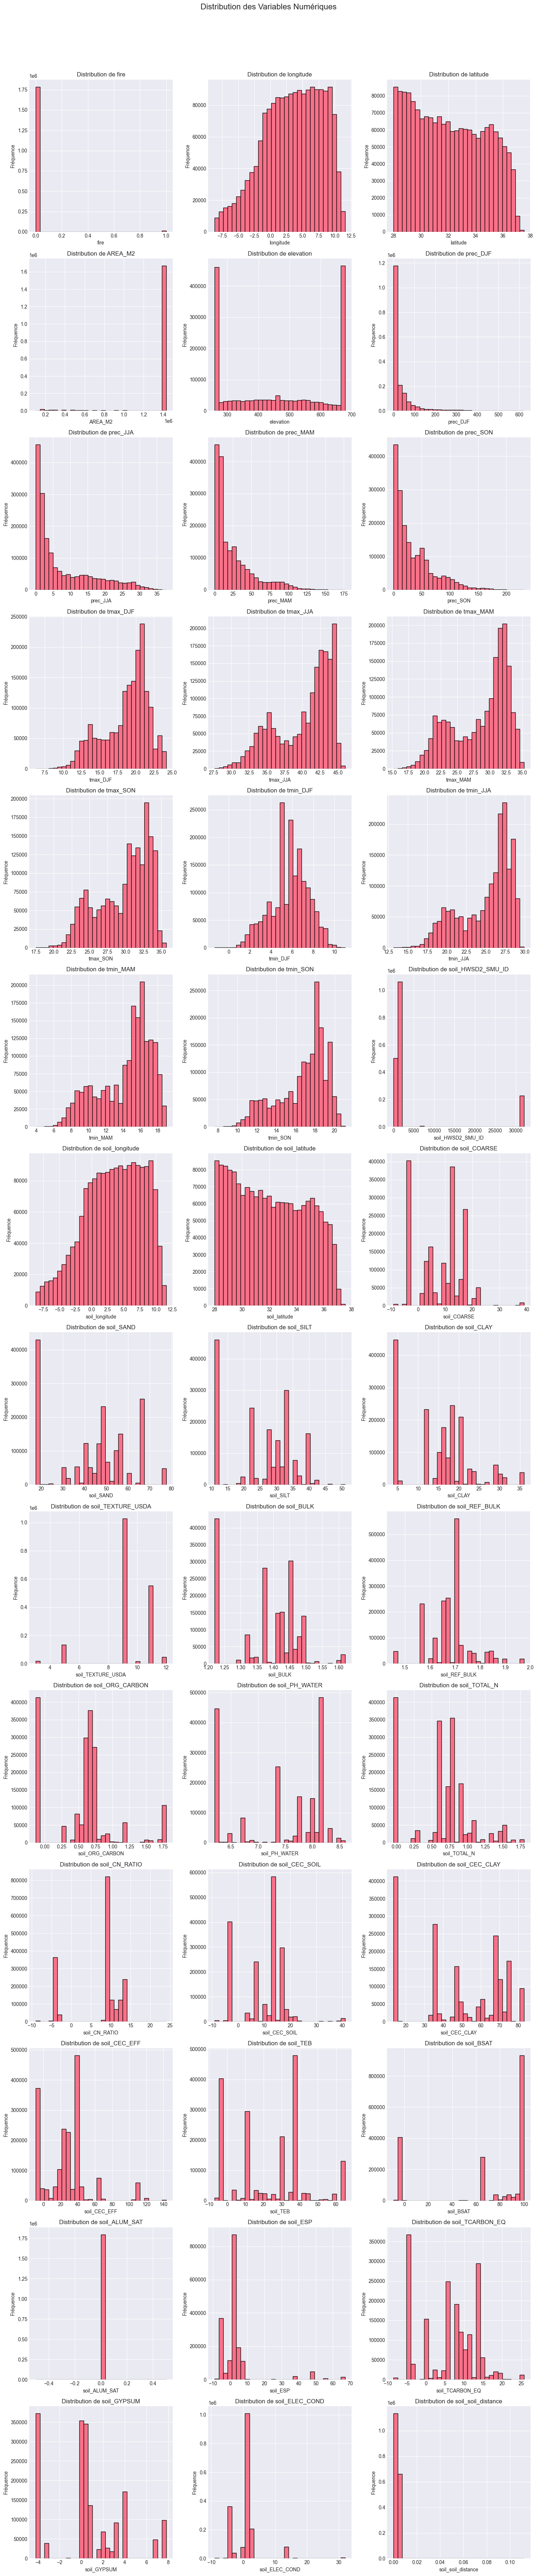

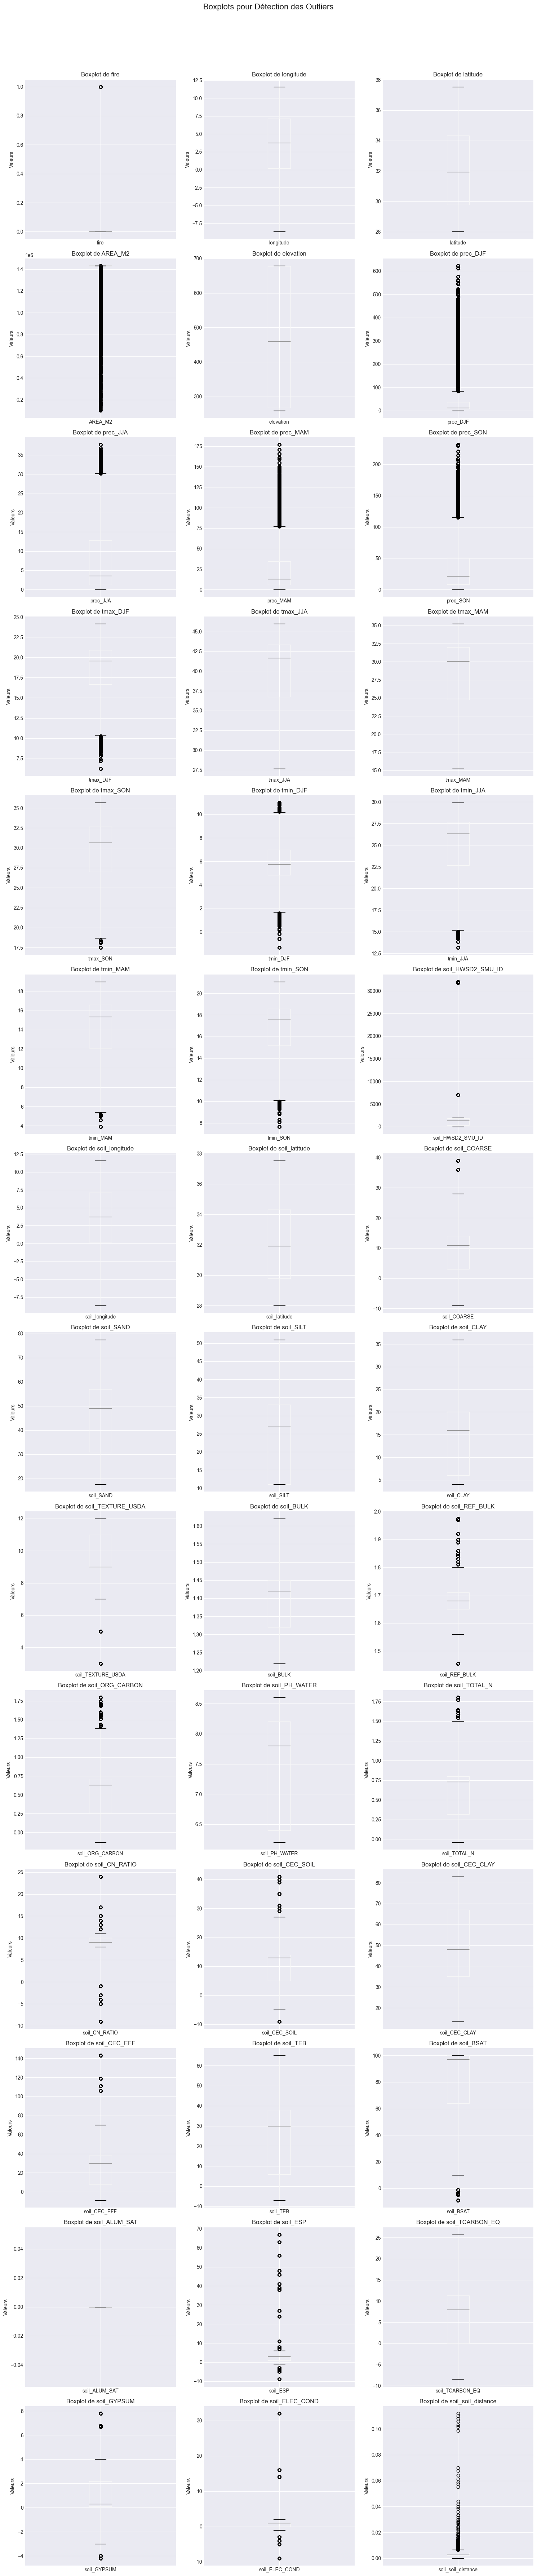

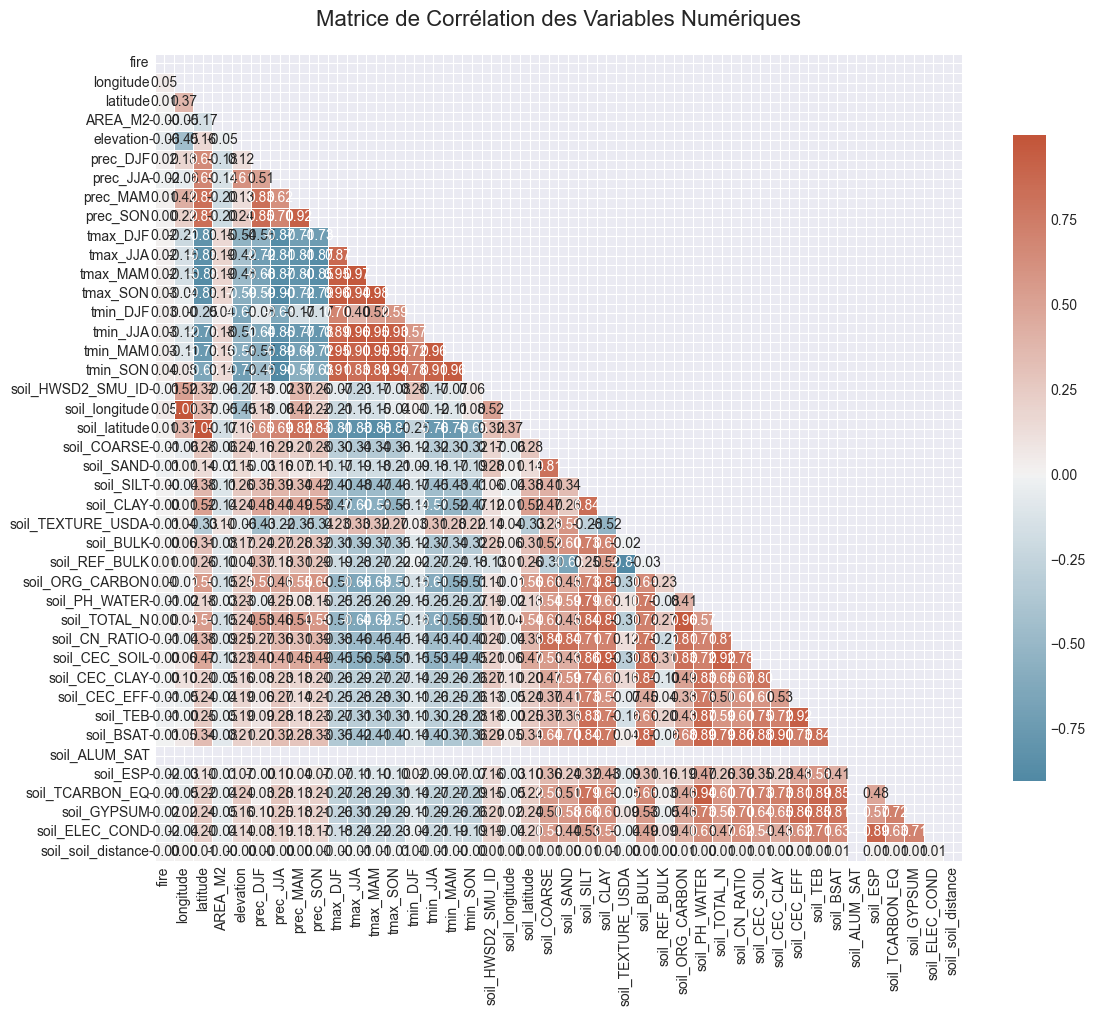

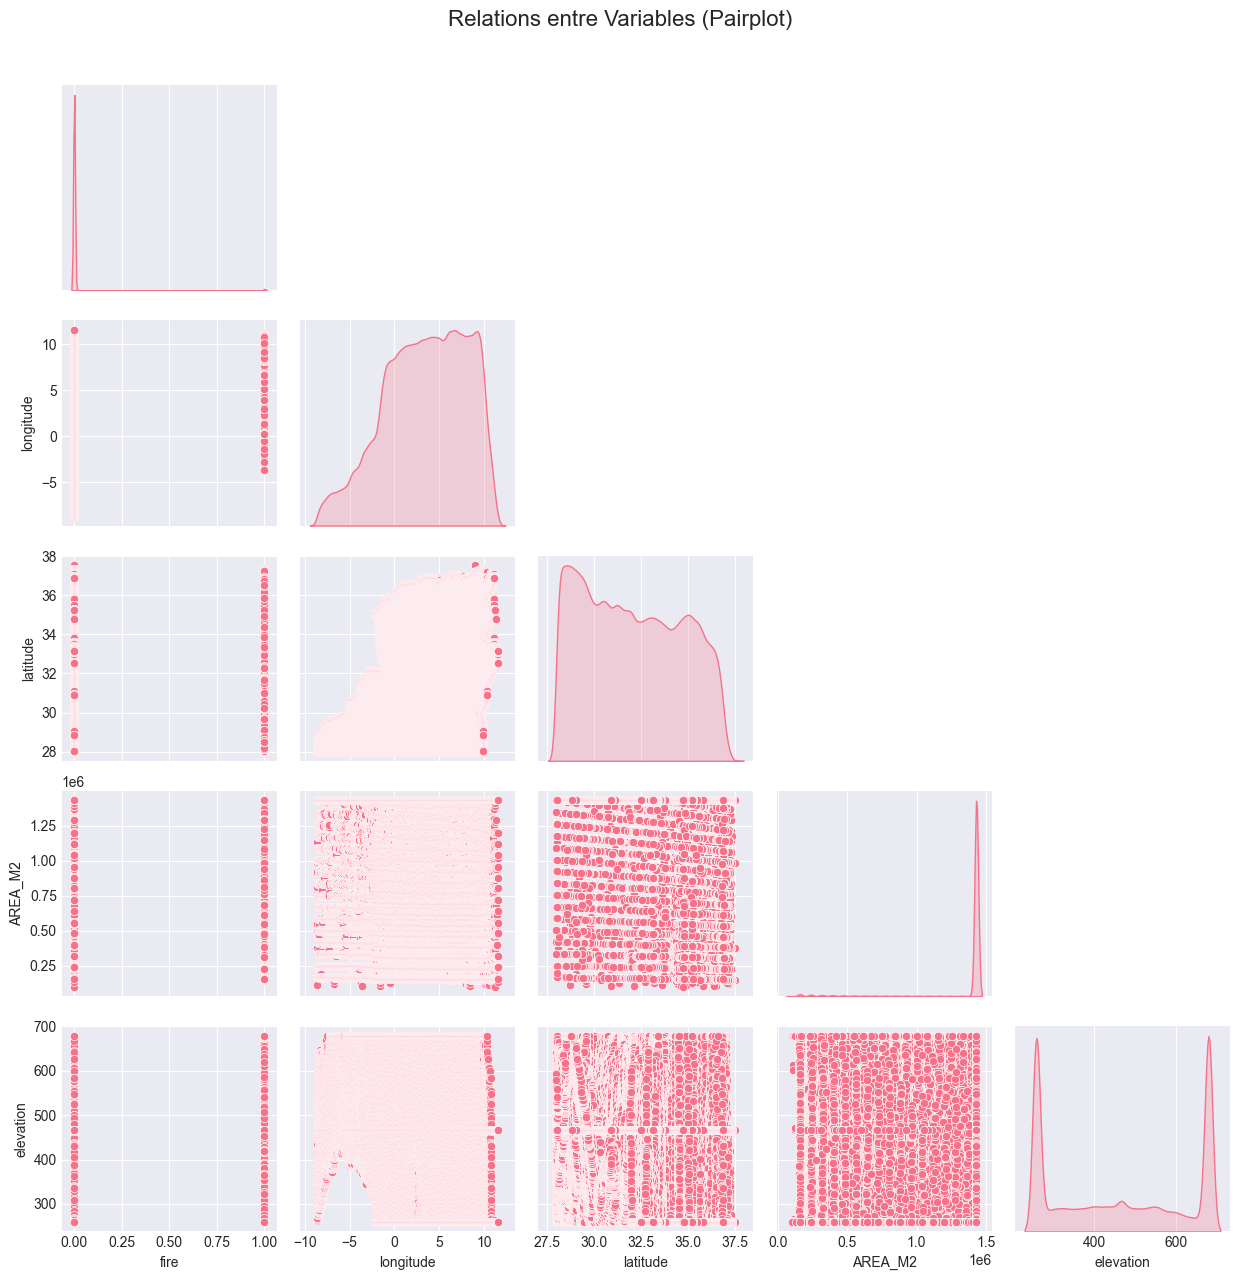


11. DÉTECTION DES OUTLIERS (MÉTHODE IQR)
----------------------------------------
Variables avec des outliers détectés :
                    outliers_count  outliers_percent
fire                       12529.0          0.696982
AREA_M2                   130389.0          7.253472
prec_DJF                  192274.0         10.696103
prec_JJA                   24145.0          1.343174
prec_MAM                  128154.0          7.129141
prec_SON                   60617.0          3.372092
tmax_DJF                    8377.0          0.466008
tmax_SON                     419.0          0.023309
tmin_DJF                   21504.0          1.196256
tmin_JJA                    2269.0          0.126223
tmin_MAM                     518.0          0.028816
tmin_SON                    4982.0          0.277146
soil_HWSD2_SMU_ID         232132.0         12.913383
soil_COARSE                10322.0          0.574208
soil_TEXTURE_USDA         153381.0          8.532505
soil_REF_BULK             2051

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# 1. Chargement des données
path = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_mergedFFF.csv"
df = pd.read_csv(path)

print("=" * 60)
print("ANALYSE EXPLORATOIRE DU DATASET")
print("=" * 60)

# 2. Aperçu général
print("\n1. APERÇU GÉNÉRAL")
print("-" * 40)
print(f"Dimensions du dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes")

# 3. Affichage des premières lignes
print("\n2. PREMIÈRES LIGNES DU DATASET")
print("-" * 40)
print(df.head())

# 4. Informations sur les colonnes
print("\n3. INFORMATIONS SUR LES COLONNES")
print("-" * 40)
print(df.info())

# 5. Types de données
print("\n4. RÉPARTITION DES TYPES DE DONNÉES")
print("-" * 40)
type_counts = df.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"{dtype}: {count} colonnes")

# 6. Statistiques descriptives
print("\n5. STATISTIQUES DESCRIPTIVES")
print("-" * 40)
print(df.describe(include='all').transpose())

# 7. Vérification des valeurs manquantes
print("\n6. VALEURS MANQUANTES")
print("-" * 40)
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Valeurs_manquantes': missing_data,
    'Pourcentage': missing_percent
})
missing_df = missing_df[missing_df['Valeurs_manquantes'] > 0].sort_values('Pourcentage', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("Aucune valeur manquante détectée !")

# 8. Identification des doublons
print("\n7. DOUBLONS")
print("-" * 40)
duplicates = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {duplicates}")

# 9. Analyse des colonnes catégorielles
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print("\n8. ANALYSE DES VARIABLES CATÉGORIELLES")
    print("-" * 40)
    for col in categorical_cols:
        unique_values = df[col].nunique()
        print(f"\nColonne: {col}")
        print(f"  Nombre de valeurs uniques: {unique_values}")
        if unique_values <= 10:  # Afficher les catégories si peu nombreuses
            print(f"  Valeurs: {df[col].unique()}")
            print(f"  Distribution:")
            print(df[col].value_counts())

# 10. Analyse des colonnes numériques
numerical_cols = df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print("\n9. ANALYSE DES VARIABLES NUMÉRIQUES")
    print("-" * 40)
    
    # Statistiques détaillées pour chaque colonne numérique
    stats_df = pd.DataFrame(index=numerical_cols)
    stats_df['Moyenne'] = df[numerical_cols].mean()
    stats_df['Médiane'] = df[numerical_cols].median()
    stats_df['Écart-type'] = df[numerical_cols].std()
    stats_df['Min'] = df[numerical_cols].min()
    stats_df['Max'] = df[numerical_cols].max()
    stats_df['Skewness'] = df[numerical_cols].skew()
    stats_df['Kurtosis'] = df[numerical_cols].kurt()
    
    print(stats_df.round(3))

# 11. Visualisations
print("\n10. CRÉATION DES VISUALISATIONS...")
print("-" * 40)

# Création d'un dossier pour sauvegarder les graphiques
import os
output_dir = "C:\\Users\\DELL\\Desktop\\project_fire\\analysis_plots"
os.makedirs(output_dir, exist_ok=True)

# a. Distribution des variables numériques
if len(numerical_cols) > 0:
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(numerical_cols):
        if idx < len(axes):
            df[col].hist(ax=axes[idx], bins=30, edgecolor='black')
            axes[idx].set_title(f'Distribution de {col}')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Fréquence')
    
    # Masquer les axes vides
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Distribution des Variables Numériques', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'distributions_numeriques.png'), dpi=300, bbox_inches='tight')
    plt.show()

# b. Boxplots pour détecter les outliers
if len(numerical_cols) > 0:
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(numerical_cols):
        if idx < len(axes):
            df.boxplot(column=col, ax=axes[idx])
            axes[idx].set_title(f'Boxplot de {col}')
            axes[idx].set_ylabel('Valeurs')
    
    # Masquer les axes vides
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Boxplots pour Détection des Outliers', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'boxplots_outliers.png'), dpi=300, bbox_inches='tight')
    plt.show()

# c. Matrice de corrélation (si suffisamment de variables numériques)
if len(numerical_cols) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numerical_cols].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=True, fmt='.2f', 
                center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('Matrice de Corrélation des Variables Numériques', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'matrice_correlation.png'), dpi=300, bbox_inches='tight')
    plt.show()

# d. Pairplot pour les 5 premières variables numériques
if len(numerical_cols) > 1:
    cols_to_plot = numerical_cols[:5] if len(numerical_cols) >= 5 else numerical_cols
    pairplot = sns.pairplot(df[cols_to_plot], diag_kind='kde', corner=True)
    pairplot.fig.suptitle('Relations entre Variables (Pairplot)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'pairplot.png'), dpi=300, bbox_inches='tight')
    plt.show()

# 12. Analyse des outliers avec méthode IQR
if len(numerical_cols) > 0:
    print("\n11. DÉTECTION DES OUTLIERS (MÉTHODE IQR)")
    print("-" * 40)
    
    outliers_info = {}
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count = len(outliers)
        outliers_percent = (outliers_count / len(df)) * 100
        
        if outliers_count > 0:
            outliers_info[col] = {
                'outliers_count': outliers_count,
                'outliers_percent': outliers_percent,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
    
    if outliers_info:
        outliers_df = pd.DataFrame(outliers_info).T
        print("Variables avec des outliers détectés :")
        print(outliers_df[['outliers_count', 'outliers_percent']])
    else:
        print("Aucun outlier détecté avec la méthode IQR.")

# 13. Résumé final
print("\n" + "=" * 60)
print("RÉSUMÉ DE L'ANALYSE EXPLORATOIRE")
print("=" * 60)
print(f"✓ Taille du dataset: {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"✓ Variables numériques: {len(numerical_cols)}")
print(f"✓ Variables catégorielles: {len(categorical_cols)}")
print(f"✓ Valeurs manquantes: {df.isnull().sum().sum()} ({missing_percent.max() if len(missing_df) > 0 else 0:.2f}% max)")
print(f"✓ Doublons: {duplicates}")
print(f"✓ Graphiques sauvegardés dans: {output_dir}")
print("=" * 60)

# Sauvegarde du rapport statistique
report_path = os.path.join(output_dir, 'rapport_statistiques.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("RAPPORT D'ANALYSE EXPLORATOIRE\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Dataset: {path}\n")
    f.write(f"Date d'analyse: {pd.Timestamp.now()}\n\n")
    f.write(f"Dimensions: {df.shape}\n")
    f.write(f"Colonnes: {list(df.columns)}\n\n")
    f.write(str(df.describe()))
    
print(f"\nRapport statistique sauvegardé: {report_path}")

In [40]:
import pandas as pd

path = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_mergedFFF.csv"

# Solution 2 : Analyser le fichier en morceaux
chunk_size = 100000  # Nombre de lignes par morceau
total_rows = 0
nan_counts = {}
columns = None  # Pour stocker les noms de colonnes

for chunk in pd.read_csv(path, chunksize=chunk_size, low_memory=True):
    total_rows += len(chunk)
    
    # Stocker les colonnes (premier morceau)
    if columns is None:
        columns = chunk.columns.tolist()
    
    # Compter les NaN dans ce morceau
    nan_in_chunk = chunk.isna().sum()
    
    # Accumuler les comptes
    for col, count in nan_in_chunk.items():
        nan_counts[col] = nan_counts.get(col, 0) + count

print(f"Nombre total de lignes : {total_rows:,}")
print(f"Nombre de colonnes : {len(columns)}")
print("\nValeurs manquantes par colonne :")
print("=" * 50)

for col in columns:
    count = nan_counts.get(col, 0)
    percentage = (count / total_rows) * 100 if total_rows > 0 else 0
    print(f"{col}: {count:,} NaN ({percentage:.2f}%)")

total_nan = sum(nan_counts.values())
print(f"\nTotal général de NaN : {total_nan:,}")
print(f"Pourcentage total : {(total_nan / (total_rows * len(columns)) * 100):.2f}%")

Nombre total de lignes : 1,797,608
Nombre de colonnes : 48

Valeurs manquantes par colonne :
fire: 0 NaN (0.00%)
longitude: 0 NaN (0.00%)
latitude: 0 NaN (0.00%)
AREA_M2: 0 NaN (0.00%)
LCCCODE: 0 NaN (0.00%)
elevation: 0 NaN (0.00%)
prec_DJF: 0 NaN (0.00%)
prec_JJA: 0 NaN (0.00%)
prec_MAM: 0 NaN (0.00%)
prec_SON: 0 NaN (0.00%)
tmax_DJF: 0 NaN (0.00%)
tmax_JJA: 0 NaN (0.00%)
tmax_MAM: 0 NaN (0.00%)
tmax_SON: 0 NaN (0.00%)
tmin_DJF: 0 NaN (0.00%)
tmin_JJA: 0 NaN (0.00%)
tmin_MAM: 0 NaN (0.00%)
tmin_SON: 0 NaN (0.00%)
soil_HWSD2_SMU_ID: 0 NaN (0.00%)
soil_longitude: 0 NaN (0.00%)
soil_latitude: 0 NaN (0.00%)
soil_COARSE: 0 NaN (0.00%)
soil_SAND: 0 NaN (0.00%)
soil_SILT: 0 NaN (0.00%)
soil_CLAY: 0 NaN (0.00%)
soil_TEXTURE_USDA: 0 NaN (0.00%)
soil_TEXTURE_SOTER: 0 NaN (0.00%)
soil_BULK: 0 NaN (0.00%)
soil_REF_BULK: 0 NaN (0.00%)
soil_ORG_CARBON: 0 NaN (0.00%)
soil_PH_WATER: 0 NaN (0.00%)
soil_TOTAL_N: 0 NaN (0.00%)
soil_CN_RATIO: 0 NaN (0.00%)
soil_CEC_SOIL: 0 NaN (0.00%)
soil_CEC_CLAY: 0 N

C:\Users\DELL\AppData\Local\Temp\ipykernel_13392\1886062526.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, low_memory=True)


✅ Données chargées : 1797608 lignes × 48 colonnes

ANALYSE PRÉLIMINAIRE DES DONNÉES

Premières lignes :
   fire  longitude  latitude     AREA_M2 LCCCODE  elevation  prec_DJF  \
0     1    5.53337  35.70751   309903.24   21518      679.0   115.025   
1     1    6.46961  32.13579  1431818.51    6004      259.0     9.475   
2     1    6.97630  32.35563  1431818.51    6004      259.0    10.425   
3     1    9.39581  28.19791  1431818.51    6001      616.0     8.950   
4     1    9.49323  28.12826  1431818.51    6001      589.0     8.200   

   prec_JJA   prec_MAM    prec_SON  ...  soil_ALUM_SAT  soil_ESP  \
0    19.675  60.275000  106.825000  ...            0.0         3   
1     2.300  16.900002   16.850000  ...            0.0         4   
2     2.200  21.075000   16.675001  ...            0.0         2   
3     1.000  10.225000    4.475000  ...            0.0         3   
4     1.000  10.200000    3.800000  ...            0.0         3   

   soil_TCARBON_EQ  soil_GYPSUM  soil_ELEC_COND 

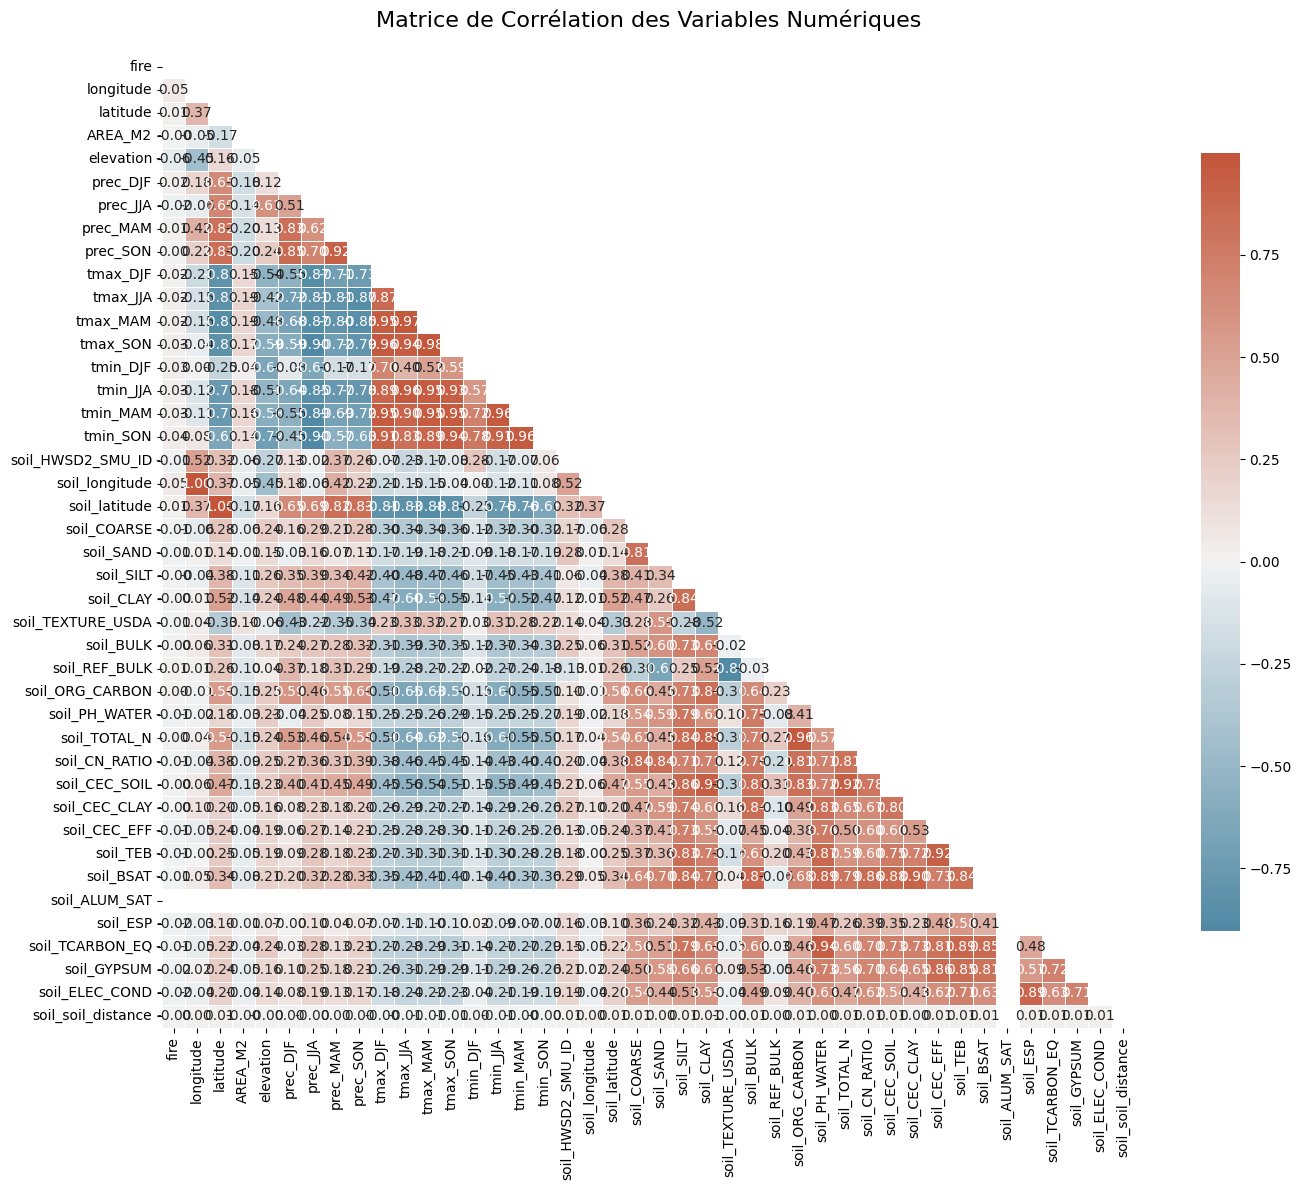


ANALYSE DE VARIANCE DES COLONNES

📉 Colonnes avec faible variance (CV < 0.01) :
soil_ALUM_SAT: CV = 0.000000

ANALYSE DES COLONNES DUPLIQUÉES

🔁 Colonnes dupliquées :
Aucune colonne dupliquée détectée

SYNTHÈSE DES COLONNES À SUPPRIMER

2. Colonnes constantes : 1 colonnes
   ['soil_ALUM_SAT']

3. Colonnes fortement corrélées : 8 colonnes
   ['tmax_MAM', 'soil_latitude', 'tmin_JJA', 'tmin_SON', 'soil_TOTAL_N', 'tmax_SON', 'soil_longitude', 'tmin_MAM']

4. Colonnes avec faible variance : 1 colonnes
   ['soil_ALUM_SAT']

📊 TOTAL des colonnes à supprimer : 9
📊 Colonnes restantes après suppression : 39

CONFIRMATION DE SUPPRESSION
Colonnes à supprimer (9) :
   1. soil_ALUM_SAT
   2. tmax_MAM
   3. soil_latitude
   4. tmin_JJA
   5. tmin_SON
   6. soil_TOTAL_N
   7. tmax_SON
   8. soil_longitude
   9. tmin_MAM

❌ Suppression annulée.

ANALYSE DES COLONNES CATÉGORIELLES
Analyse des colonnes catégorielles :

LCCCODE:
  Nombre de valeurs uniques : 26

soil_TEXTURE_SOTER:
  Nombre de valeurs un

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Charger les données
path = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_mergedFFF.csv"
try:
    df = pd.read_csv(path, low_memory=True)
    print(f"✅ Données chargées : {df.shape[0]} lignes × {df.shape[1]} colonnes")
except MemoryError:
    # Charger par morceaux si fichier trop volumineux
    print("⚠️ Fichier volumineux détecté, chargement par morceaux...")
    chunks = []
    for chunk in pd.read_csv(path, chunksize=10000, low_memory=True):
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)
    print(f"✅ Données chargées : {df.shape[0]} lignes × {df.shape[1]} colonnes")

# 2. Analyse préliminaire
print("\n" + "="*60)
print("ANALYSE PRÉLIMINAIRE DES DONNÉES")
print("="*60)

# Afficher les premières lignes
print("\nPremières lignes :")
print(df.head())

# Informations sur les colonnes
print("\nInformations sur les colonnes :")
print(df.info())

# 3. Identification des types de données
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n🔹 Colonnes catégorielles ({len(categorical_cols)}) :")
print(categorical_cols)
print(f"\n🔹 Colonnes numériques ({len(numerical_cols)}) :")
print(numerical_cols)

# 4. Analyse des valeurs manquantes
print("\n" + "="*60)
print("ANALYSE DES VALEURS MANQUANTES")
print("="*60)

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Valeurs_manquantes': missing_data,
    'Pourcentage': missing_percent
}).sort_values('Pourcentage', ascending=False)

# Afficher les colonnes avec plus de 30% de valeurs manquantes
high_missing = missing_df[missing_df['Pourcentage'] > 30]
print(f"\n❌ Colonnes avec >30% de valeurs manquantes ({len(high_missing)}) :")
if len(high_missing) > 0:
    print(high_missing)
else:
    print("Aucune")

# 5. Analyse de variance (colonnes constantes)
print("\n" + "="*60)
print("ANALYSE DES COLONNES CONSTANTES")
print("="*60)

constant_cols = []
for col in df.columns:
    if df[col].nunique() == 1:
        constant_cols.append(col)

print(f"🔍 Colonnes constantes ({len(constant_cols)}) :")
if constant_cols:
    print(constant_cols)
else:
    print("Aucune colonne constante")

# 6. Analyse de corrélation (pour colonnes numériques)
print("\n" + "="*60)
print("ANALYSE DES CORRÉLATIONS")
print("="*60)

if len(numerical_cols) > 1:
    # Calculer la matrice de corrélation
    correlation_matrix = df[numerical_cols].corr()
    
    # Identifier les paires fortement corrélées
    high_corr_pairs = []
    threshold = 0.95  # Seuil de corrélation élevée
    
    for i in range(len(numerical_cols)):
        for j in range(i+1, len(numerical_cols)):
            col1 = numerical_cols[i]
            col2 = numerical_cols[j]
            corr_value = abs(correlation_matrix.loc[col1, col2])
            
            if corr_value > threshold:
                high_corr_pairs.append({
                    'Colonne_1': col1,
                    'Colonne_2': col2,
                    'Corrélation': corr_value
                })
    
    print(f"\n🤝 Paires fortement corrélées (|r| > {threshold}) :")
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        print(high_corr_df.sort_values('Corrélation', ascending=False))
        
        # Identifier les colonnes à supprimer (garder une seule de chaque paire)
        cols_to_remove_corr = set()
        for pair in high_corr_pairs:
            # On garde la première colonne, on supprime la seconde
            cols_to_remove_corr.add(pair['Colonne_2'])
        
        print(f"\n⚠️ Colonnes à considérer pour suppression (corrélation) :")
        print(list(cols_to_remove_corr))
    else:
        print("Aucune paire fortement corrélée détectée")
        cols_to_remove_corr = set()
    
    # Visualisation de la matrice de corrélation
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=True, fmt='.2f',
                center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('Matrice de Corrélation des Variables Numériques', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Pas assez de colonnes numériques pour l'analyse de corrélation")
    cols_to_remove_corr = set()

# 7. Analyse des colonnes avec peu de variance
print("\n" + "="*60)
print("ANALYSE DE VARIANCE DES COLONNES")
print("="*60)

if len(numerical_cols) > 0:
    # Calculer le coefficient de variation
    cv_threshold = 0.01  # Seuil de faible variation
    
    low_variance_cols = []
    for col in numerical_cols:
        if df[col].std() == 0:
            low_variance_cols.append((col, 0))
        else:
            cv = df[col].std() / df[col].mean()
            if abs(cv) < cv_threshold and df[col].std() > 0:
                low_variance_cols.append((col, cv))
    
    print(f"\n📉 Colonnes avec faible variance (CV < {cv_threshold}) :")
    if low_variance_cols:
        for col, cv in low_variance_cols:
            print(f"{col}: CV = {cv:.6f}")
    else:
        print("Aucune")
    
    # Colonnes à supprimer pour faible variance
    cols_to_remove_variance = [col for col, _ in low_variance_cols]

# 8. Analyse des colonnes dupliquées
print("\n" + "="*60)
print("ANALYSE DES COLONNES DUPLIQUÉES")
print("="*60)

# Détecter les colonnes avec les mêmes valeurs
duplicate_cols = []
checked_cols = []

for i in range(len(df.columns)):
    col1 = df.columns[i]
    if col1 in checked_cols:
        continue
    
    duplicates_of_col1 = []
    for j in range(i+1, len(df.columns)):
        col2 = df.columns[j]
        
        # Vérifier si les deux colonnes sont identiques
        if df[col1].equals(df[col2]):
            duplicates_of_col1.append(col2)
    
    if duplicates_of_col1:
        duplicate_cols.append({
            'colonne_reference': col1,
            'colonnes_dupliquees': duplicates_of_col1
        })
        checked_cols.extend([col1] + duplicates_of_col1)

print(f"\n🔁 Colonnes dupliquées :")
if duplicate_cols:
    for dup in duplicate_cols:
        print(f"{dup['colonne_reference']} est dupliquée dans: {dup['colonnes_dupliquees']}")
    
    # Colonnes à supprimer (toutes sauf la première de chaque groupe)
    cols_to_remove_duplicate = []
    for dup in duplicate_cols:
        cols_to_remove_duplicate.extend(dup['colonnes_dupliquees'])
else:
    print("Aucune colonne dupliquée détectée")
    cols_to_remove_duplicate = []

# 9. Synthèse des colonnes à supprimer
print("\n" + "="*60)
print("SYNTHÈSE DES COLONNES À SUPPRIMER")
print("="*60)

# Combiner toutes les listes de colonnes à supprimer
all_cols_to_remove = set()

# 1. Colonnes avec >30% de valeurs manquantes
if len(high_missing) > 0:
    cols_high_missing = high_missing.index.tolist()
    all_cols_to_remove.update(cols_high_missing)
    print(f"1. Valeurs manquantes >30% : {len(cols_high_missing)} colonnes")
    print(f"   {cols_high_missing}")

# 2. Colonnes constantes
if constant_cols:
    all_cols_to_remove.update(constant_cols)
    print(f"\n2. Colonnes constantes : {len(constant_cols)} colonnes")
    print(f"   {constant_cols}")

# 3. Colonnes fortement corrélées (garder une seule)
if cols_to_remove_corr:
    all_cols_to_remove.update(cols_to_remove_corr)
    print(f"\n3. Colonnes fortement corrélées : {len(cols_to_remove_corr)} colonnes")
    print(f"   {list(cols_to_remove_corr)}")

# 4. Colonnes avec faible variance
if 'cols_to_remove_variance' in locals() and cols_to_remove_variance:
    all_cols_to_remove.update(cols_to_remove_variance)
    print(f"\n4. Colonnes avec faible variance : {len(cols_to_remove_variance)} colonnes")
    print(f"   {cols_to_remove_variance}")

# 5. Colonnes dupliquées
if cols_to_remove_duplicate:
    all_cols_to_remove.update(cols_to_remove_duplicate)
    print(f"\n5. Colonnes dupliquées : {len(cols_to_remove_duplicate)} colonnes")
    print(f"   {cols_to_remove_duplicate}")

print(f"\n📊 TOTAL des colonnes à supprimer : {len(all_cols_to_remove)}")
print(f"📊 Colonnes restantes après suppression : {len(df.columns) - len(all_cols_to_remove)}")

# 10. Demander confirmation avant suppression
print("\n" + "="*60)
print("CONFIRMATION DE SUPPRESSION")
print("="*60)

if len(all_cols_to_remove) > 0:
    print(f"Colonnes à supprimer ({len(all_cols_to_remove)}) :")
    for i, col in enumerate(all_cols_to_remove, 1):
        print(f"  {i:2d}. {col}")
    
    confirmation = input(f"\nVoulez-vous supprimer ces {len(all_cols_to_remove)} colonnes ? (oui/non): ")
    
    if confirmation.lower() in ['oui', 'yes', 'y', 'o']:
        # Créer une copie avant suppression
        df_cleaned = df.copy()
        
        # Supprimer les colonnes
        df_cleaned = df_cleaned.drop(columns=list(all_cols_to_remove))
        
        print(f"\n✅ Suppression effectuée !")
        print(f"   Avant : {df.shape[1]} colonnes")
        print(f"   Après : {df_cleaned.shape[1]} colonnes")
        print(f"   Supprimées : {len(all_cols_to_remove)} colonnes")
        
        # Sauvegarder le nouveau dataset
        output_path = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_cleaned.csv"
        df_cleaned.to_csv(output_path, index=False)
        print(f"\n💾 Données nettoyées sauvegardées : {output_path}")
        
        # Afficher les colonnes restantes
        print("\n🔹 Colonnes restantes :")
        for i, col in enumerate(df_cleaned.columns, 1):
            print(f"  {i:2d}. {col}")
    else:
        print("\n❌ Suppression annulée.")
else:
    print("Aucune colonne à supprimer détectée.")

# 11. Analyse supplémentaire pour les colonnes catégorielles
print("\n" + "="*60)
print("ANALYSE DES COLONNES CATÉGORIELLES")
print("="*60)

if categorical_cols:
    print("Analyse des colonnes catégorielles :")
    for col in categorical_cols:
        unique_count = df[col].nunique()
        print(f"\n{col}:")
        print(f"  Nombre de valeurs uniques : {unique_count}")
        
        if unique_count <= 10:
            print(f"  Valeurs : {df[col].unique().tolist()}")
        
        if unique_count > 50:
            print(f"  ⚠️  Nombre élevé de catégories, peut nécessiter un traitement spécial")
        
        # Vérifier le déséquilibre
        if unique_count <= 10:
            value_counts = df[col].value_counts(normalize=True)
            if len(value_counts) > 1:
                major_ratio = value_counts.iloc[0]
                if major_ratio > 0.9:
                    print(f"  ⚠️  Déséquilibre important : {major_ratio:.1%} pour la catégorie majoritaire")

# 12. Suggestions pour l'ingénierie des features
print("\n" + "="*60)
print("SUGGESTIONS POUR L'INGÉNIERIE DES FEATURES")
print("="*60)

print("\nPour votre projet sur les feux de forêt, considérez :")
print("1. Variables climatiques importantes :")
print("   - Température (max, min, moyenne)")
print("   - Humidité relative")
print("   - Vitesse du vent")
print("   - Précipitations")
print("   - Indice de sécheresse")

print("\n2. Variables du sol importantes :")
print("   - Humidité du sol")
print("   - Teneur en matière organique")
print("   - Texture du sol (argile, limon, sable)")
print("   - pH du sol")

print("\n3. Variables spatiales importantes :")
print("   - Altitude/élévation")
print("   - Pente")
print("   - Orientation (aspect)")
print("   - Distance aux routes/installations")

print("\n4. Variables temporelles :")
print("   - Mois/saison")
print("   - Jours depuis la dernière pluie")
print("   - Température cumulative")

print("\n5. Variables dérivées potentielles :")
print("   - Indice de risque incendie (combinaison de variables)")
print("   - Moyennes mobiles des conditions météo")
print("   - Différences temporelles (Δtempérature, Δhumidité)")

# 13. Exporter le rapport d'analyse
print("\n" + "="*60)
print("EXPORT DU RAPPORT D'ANALYSE")
print("="*60)

# Créer un rapport détaillé
report_content = f"""
RAPPORT D'ANALYSE DES DONNÉES - PROJET FEUX DE FORÊT
Date: {pd.Timestamp.now()}
Fichier source: {path}
Dimensions originales: {df.shape}

=== SYNTHÈSE ===
Colonnes totales: {len(df.columns)}
Colonnes numériques: {len(numerical_cols)}
Colonnes catégorielles: {len(categorical_cols)}
Colonnes à supprimer identifiées: {len(all_cols_to_remove)}

=== COLONNES IDENTIFIÉES POUR SUPPRESSION ===
"""

if all_cols_to_remove:
    for col in all_cols_to_remove:
        reason = []
        if col in high_missing.index.tolist():
            reason.append("Valeurs manquantes >30%")
        if col in constant_cols:
            reason.append("Colonne constante")
        if col in cols_to_remove_corr:
            reason.append("Fortement corrélée")
        if 'cols_to_remove_variance' in locals() and col in cols_to_remove_variance:
            reason.append("Faible variance")
        if col in cols_to_remove_duplicate:
            reason.append("Dupliquée")
        
        report_content += f"\n{col}: {', '.join(reason)}"
else:
    report_content += "\nAucune colonne identifiée pour suppression."

# Sauvegarder le rapport
report_path = "C:\\Users\\DELL\\Desktop\\project_fire\\analysis_report.txt"
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_content)

print(f"📄 Rapport sauvegardé : {report_path}")

In [4]:
import pandas as pd

# Définir les chemins
input_file = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_mergedFFF.csv"
output_file = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\dataset_cleanFFF.csv"

# Liste des colonnes à supprimer
cols_to_delete = [
    'soil_ALUM_SAT', 'soil_TOTAL_N', 
    'soil_longitude', 'soil_latitude', 'longitude', 'latitude'
]

# Charger et supprimer
df = pd.read_csv(input_file, low_memory=True)
df = df.drop(columns=cols_to_delete, errors='ignore')
df.to_csv(output_file, index=False)

print(f"✅ Fichier nettoyé : {output_file}")
print(f"Dimensions : {df.shape}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_13392\2530379847.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file, low_memory=True)


✅ Fichier nettoyé : C:\Users\DELL\Desktop\project_fire\data\processed\dataset_cleanFFF.csv
Dimensions : (1797608, 42)


In [6]:
import pandas as pd

# Charger le fichier
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\dataset_cleanFFF.csv"
df = pd.read_csv(path)

# Affichage propre des 10 premières lignes
df.head(10).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt')]},
     {'selector': 'td', 'props': [('font-size', '11pt')]}]
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13392\442116822.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,fire,AREA_M2,LCCCODE,elevation,prec_DJF,prec_JJA,prec_MAM,prec_SON,tmax_DJF,tmax_JJA,tmax_MAM,tmax_SON,tmin_DJF,tmin_JJA,tmin_MAM,tmin_SON,soil_HWSD2_SMU_ID,soil_COARSE,soil_SAND,soil_SILT,soil_CLAY,soil_TEXTURE_USDA,soil_TEXTURE_SOTER,soil_BULK,soil_REF_BULK,soil_ORG_CARBON,soil_PH_WATER,soil_CN_RATIO,soil_CEC_SOIL,soil_CEC_CLAY,soil_CEC_EFF,soil_TEB,soil_BSAT,soil_ESP,soil_TCARBON_EQ,soil_GYPSUM,soil_ELEC_COND,soil_TEXTURE_-,soil_TEXTURE_C,soil_TEXTURE_F,soil_TEXTURE_M,soil_soil_distance
0,1,309903.240000,21518,679.000000,115.025000,19.675000,60.275000,106.825000,8.833333,29.666666,17.166666,19.416666,1.250000,16.250000,6.500000,10.000000,1238,22.000000,51.000000,29.000000,20.000000,9.000000,M,1.370000,1.720000,1.795250,6.700000,12.000000,16,35.000000,20.000000,10.000000,64,3,0.000000,0.300000,1,False,False,False,True,0.005315
1,1,1431818.510000,6004,259.000000,9.475000,2.300000,16.900002,16.850000,19.750000,43.666668,31.666666,32.250000,6.666666,28.666666,16.916666,19.333334,1642,9.000000,55.000000,30.000000,15.000000,11.000000,M,1.420000,1.620000,0.589000,8.200000,9.000000,14,83.000000,37.000000,37.000000,99,4,9.300000,3.300000,1,False,False,False,True,0.002102
2,1,1431818.510000,6004,259.000000,10.425000,2.200000,21.075000,16.675001,19.666666,43.333332,31.333334,32.000000,6.500000,28.333334,16.666666,19.250000,1645,15.000000,64.000000,20.000000,16.000000,11.000000,M,1.530000,1.650000,0.644000,7.000000,10.000000,12,64.000000,15.000000,15.000000,94,2,1.700000,0.100000,1,False,False,False,True,0.003218
3,1,1431818.510000,6001,616.000000,8.950000,1.000000,10.225000,4.475000,19.916666,41.333332,31.500000,31.666666,4.083334,25.000000,15.083333,16.666666,1796,12.000000,57.000000,27.000000,16.000000,11.000000,M,1.430000,1.650000,0.616000,7.800000,9.000000,13,74.000000,30.000000,30.000000,100,3,8.000000,4.000000,1,False,False,False,True,0.002077
4,1,1431818.510000,6001,589.000000,8.200000,1.000000,10.200000,3.800000,20.000000,41.333332,31.666666,31.666666,5.000000,25.500000,15.666667,17.000000,1796,12.000000,57.000000,27.000000,16.000000,11.000000,M,1.430000,1.650000,0.616000,7.800000,9.000000,13,74.000000,30.000000,30.000000,100,3,8.000000,4.000000,1,False,False,False,True,0.002757
5,1,1431818.510000,6004,259.000000,10.000000,0.900000,11.900000,7.300000,21.333334,44.666668,33.000000,34.000000,6.666666,28.666666,17.333334,19.666666,36,-4.000000,17.500000,11.000000,4.000000,9.000000,-,1.220000,1.710000,-0.134750,6.200001,-4.000000,-4,13.500000,-4.000000,-4.000000,-4,-4,-4.000000,-4.000000,-4,True,False,False,False,0.003466
6,1,1431818.510000,6004,259.000000,10.000000,0.900000,11.900000,7.300000,21.333334,44.666668,33.000000,34.000000,6.666666,28.666666,17.333334,19.666666,36,-4.000000,17.500000,11.000000,4.000000,9.000000,-,1.220000,1.710000,-0.134750,6.200001,-4.000000,-4,13.500000,-4.000000,-4.000000,-4,-4,-4.000000,-4.000000,-4,True,False,False,False,0.003953
7,1,1431818.510000,6001,259.000000,10.424999,1.800000,16.150002,11.425000,21.000000,44.666668,33.000000,34.000000,6.666666,29.000000,17.333334,20.000000,36,-4.000000,17.500000,11.000000,4.000000,9.000000,-,1.220000,1.710000,-0.134750,6.200001,-4.000000,-4,13.500000,-4.000000,-4.000000,-4,-4,-4.000000,-4.000000,-4,True,False,False,False,0.001962
8,1,1431818.510000,6001,259.000000,8.325000,1.800000,11.000000,12.275000,20.666666,44.333332,32.333332,33.000000,6.666666,29.000000,17.333334,19.333334,1315,12.000000,49.000000,33.000000,18.000000,9.000000,M,1.450000,1.680000,0.697000,8.200000,9.000000,14,67.000000,38.000000,38.000000,100,2,13.900000,0.200000,1,False,False,False,True,0.004092
9,1,1431818.510000,6001,259.000000,8.325000,1.800000,11.000000,12.275000,20.666666,44.333332,32.333332,33.000000,6.666666,29.000000,17.333334,19.333334,1315,12.000000,49.000000,33.000000,18.000000,9.000000,M,1.450000,1.680000,0.697000,8.200000,9.000000,14,67.000000,38.000000,38.000000,100,2,13.900000,0.200000,1,False,False,False,True,0.003626


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv("C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\dataset_cleanFFF.csv", nrows=10000)

print("🔍 ANALYSE DES VARIABLES DU SOL")
print("="*60)

# Identifier toutes les colonnes de sol
soil_columns = [col for col in df.columns if 'soil' in col.lower()]
print(f"Nombre total de colonnes 'soil' : {len(soil_columns)}")

# Afficher toutes les colonnes de sol
print("\n📋 LISTE COMPLÈTE DES VARIABLES DU SOL :")
for i, col in enumerate(soil_columns, 1):
    print(f"{i:3d}. {col}")

# Analyse détaillée de chaque variable de sol
print("\n" + "="*60)
print("ANALYSE DÉTAILLÉE PAR VARIABLE")
print("="*60)

analysis_results = []

for col in soil_columns:
    if col in df.columns:
        data = df[col]
        
        # Statistiques de base
        stats = {
            'colonne': col,
            'type': str(data.dtype),
            'valeurs_uniques': data.nunique(),
            'valeurs_manquantes': data.isna().sum(),
            'pourcentage_manquantes': (data.isna().sum() / len(data)) * 100
        }
        
        # Pour les variables numériques
        if pd.api.types.is_numeric_dtype(data):
            stats['min'] = data.min()
            stats['max'] = data.max()
            stats['moyenne'] = data.mean()
            stats['ecart_type'] = data.std()
            stats['median'] = data.median()
            
            # Coefficient de variation
            if stats['moyenne'] != 0:
                stats['CV'] = stats['ecart_type'] / abs(stats['moyenne'])
            else:
                stats['CV'] = 0
                
            # Détection de valeurs constantes ou aberrantes
            stats['est_constante'] = (stats['valeurs_uniques'] == 1)
            stats['CV_faible'] = (stats['CV'] < 0.01) if 'CV' in stats else False
            
            # Vérifier les valeurs négatives (potentiellement des codes d'erreur)
            negative_count = (data < 0).sum()
            stats['valeurs_negatives'] = negative_count
            stats['pourcentage_negatives'] = (negative_count / len(data)) * 100
            
        analysis_results.append(stats)

# Convertir en DataFrame pour analyse
analysis_df = pd.DataFrame(analysis_results)

# Trier par pourcentage de valeurs manquantes
analysis_df = analysis_df.sort_values('pourcentage_manquantes', ascending=False)

print("\n📊 CLASSEMENT PAR VALEURS MANQUANTES :")
print("-"*60)
print(analysis_df[['colonne', 'type', 'valeurs_uniques', 'pourcentage_manquantes']].head(15).to_string())

# Identifier les problèmes
print("\n🔴 PROBLÈMES IDENTIFIÉS :")
print("="*60)

# 1. Colonnes avec beaucoup de valeurs manquantes
high_missing = analysis_df[analysis_df['pourcentage_manquantes'] > 30]
if len(high_missing) > 0:
    print("\n1. COLONNES AVEC >30% DE VALEURS MANQUANTES :")
    for _, row in high_missing.iterrows():
        print(f"   ❌ {row['colonne']} : {row['pourcentage_manquantes']:.1f}% manquantes")

# 2. Colonnes constantes
constant_cols = analysis_df[analysis_df['est_constante'] == True]
if len(constant_cols) > 0:
    print("\n2. COLONNES CONSTANTES (pas de variation) :")
    for _, row in constant_cols.iterrows():
        print(f"   ❌ {row['colonne']} : {row['valeurs_uniques']} valeur unique")

# 3. Colonnes avec faible variation (CV < 0.01)
if 'CV_faible' in analysis_df.columns:
    low_var_cols = analysis_df[analysis_df['CV_faible'] == True]
    if len(low_var_cols) > 0:
        print("\n3. COLONNES AVEC FAIBLE VARIATION (CV < 0.01) :")
        for _, row in low_var_cols.iterrows():
            print(f"   ⚠️  {row['colonne']} : CV = {row.get('CV', 0):.6f}")

# 4. Colonnes avec valeurs négatives suspectes
if 'pourcentage_negatives' in analysis_df.columns:
    negative_cols = analysis_df[analysis_df['pourcentage_negatives'] > 50]
    if len(negative_cols) > 0:
        print("\n4. COLONNES AVEC BEAUCOUP DE VALEURS NÉGATIVES (>50%) :")
        for _, row in negative_cols.iterrows():
            print(f"   ❓ {row['colonne']} : {row['pourcentage_negatives']:.1f}% négatives")

# Analyse sémantique des colonnes
print("\n🧠 ANALYSE SÉMANTIQUE DES VARIABLES DU SOL :")
print("="*60)

# Catégoriser les variables
categories = {
    'texture': ['SAND', 'SILT', 'CLAY', 'TEXTURE', 'COARSE'],
    'chimie': ['PH', 'CARBON', 'NITROGEN', 'CEC', 'GYPSUM', 'ESP', 'BSAT', 'TEB', 'CN'],
    'physique': ['BULK', 'DENSITY', 'MOISTURE', 'DEPTH'],
    'spatial': ['LATITUDE', 'LONGITUDE', 'DISTANCE', 'ID', 'SMU'],
    'autres': ['ALUM', 'ELEC', 'REF']
}

for category, keywords in categories.items():
    cols_in_category = []
    for col in soil_columns:
        for keyword in keywords:
            if keyword in col.upper():
                cols_in_category.append(col)
                break
    
    if cols_in_category:
        print(f"\n📁 {category.upper()} ({len(cols_in_category)} variables) :")
        for col in cols_in_category:
            # Vérifier si cette colonne a des problèmes
            problems = []
            if col in high_missing['colonne'].values:
                problems.append("beaucoup de NaN")
            if col in constant_cols['colonne'].values:
                problems.append("constante")
            
            if problems:
                print(f"   ⚠️  {col} ({', '.join(problems)})")
            else:
                print(f"   ✓ {col}")

# Analyse de corrélation entre variables de sol
print("\n🔗 ANALYSE DES CORRÉLATIONS ENTRE VARIABLES DU SOL :")
print("="*60)

# Sélectionner les variables numériques de sol
numeric_soil_cols = []
for col in soil_columns:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        # Exclure les colonnes avec beaucoup de NaN
        if df[col].isna().sum() / len(df) < 0.5:  # Moins de 50% de NaN
            numeric_soil_cols.append(col)

if len(numeric_soil_cols) > 5:
    # Calculer la matrice de corrélation
    corr_matrix = df[numeric_soil_cols].corr()
    
    # Trouver les paires fortement corrélées
    high_corr_pairs = []
    threshold = 0.95
    
    for i in range(len(numeric_soil_cols)):
        for j in range(i+1, len(numeric_soil_cols)):
            col1 = numeric_soil_cols[i]
            col2 = numeric_soil_cols[j]
            corr_value = abs(corr_matrix.loc[col1, col2])
            
            if corr_value > threshold:
                high_corr_pairs.append({
                    'var1': col1,
                    'var2': col2,
                    'correlation': corr_value
                })
    
    if high_corr_pairs:
        print(f"\n⚠️  VARIABLES FORTEMENT CORRÉLÉES (|r| > {threshold}) :")
        for pair in high_corr_pairs[:10]:  # Limiter à 10 paires
            print(f"   {pair['var1']} ↔ {pair['var2']} : {pair['correlation']:.3f}")
        
        # Identifier les variables à supprimer (garder une seule de chaque paire)
        cols_to_remove_corr = set()
        for pair in high_corr_pairs:
            # On garde la première, on supprime la seconde
            cols_to_remove_corr.add(pair['var2'])
        
        print(f"\n🎯 VARIABLES À SUPPRIMER (redondantes) :")
        for col in sorted(cols_to_remove_corr):
            print(f"   ❌ {col}")
    else:
        print("✅ Pas de corrélations très fortes détectées")

# Recommandations finales
print("\n" + "="*60)
print("🎯 RECOMMANDATIONS FINALES POUR VOTRE PROJET")
print("="*60)

print("\n📋 À SUPPRIMER ABSOLUMENT :")

# 1. Variables spatiales (déjà fait)
print("\n1. VARIABLES SPATIALES :")
spatial_vars = [col for col in soil_columns if any(kw in col.upper() for kw in ['LAT', 'LON', 'DISTANCE', 'ID', 'SMU'])]
for col in spatial_vars:
    print(f"   ❌ {col}")

# 2. Variables avec problèmes techniques
print("\n2. PROBLÈMES TECHNIQUES :")
technical_issues = []

# Vérifier chaque colonne problématique
for col in soil_columns:
    if col in df.columns:
        # Beaucoup de NaN
        if df[col].isna().sum() / len(df) > 0.3:
            technical_issues.append((col, f"{df[col].isna().sum()/len(df)*100:.1f}% NaN"))
        
        # Constante
        elif df[col].nunique() == 1:
            technical_issues.append((col, "constante"))
        
        # Beaucoup de valeurs négatives (potentiellement codes d'erreur)
        elif pd.api.types.is_numeric_dtype(df[col]):
            neg_count = (df[col] < 0).sum()
            if neg_count / len(df) > 0.5:
                technical_issues.append((col, f"{neg_count/len(df)*100:.1f}% valeurs négatives"))

for col, reason in technical_issues[:10]:  # Limiter l'affichage
    print(f"   ❌ {col} ({reason})")

# 3. Variables peu pertinentes pour les feux de forêt
print("\n3. PEU PERTINENTES POUR LES FEUX :")
low_relevance = [
    'soil_ALUM_SAT',  # Aluminium saturation - peu lié aux feux
    'soil_ELEC_COND',  # Conductivité électrique
    'soil_GYPSUM',     # Gypse
    'soil_ESP',        # Exchangeable Sodium Percentage
    'soil_CN_RATIO',   # Ratio C/N (trop spécifique)
    'soil_CEC_CLAY',   # CEC de l'argile (redondant)
    'soil_CEC_EFF',    # CEC effective (redondant)
    'soil_TEB',        # Total Exchangeable Bases
    'soil_REF_BULK',   # Densité de référence
]

for col in low_relevance:
    if col in soil_columns:
        print(f"   ❌ {col}")

print("\n📋 À CONSERVER (ESSENTIELLES) :")

# Variables essentielles pour les feux de forêt
essential_vars = [
    'soil_SAND',        # Sable - drainage rapide → risque feu
    'soil_SILT',        # Limon
    'soil_CLAY',        # Argile - rétention eau → protection
    'soil_TEXTURE_C',   # Argile (pourcentage)
    'soil_TEXTURE_F',   # Limon (pourcentage)
    'soil_ORG_CARBON',  # Carbone organique → végétation → combustible
    'soil_PH_WATER',    # pH → type de végétation
    'soil_BULK',        # Densité → capacité rétention eau
    'soil_MOISTURE',    # Humidité du sol (si présente)
]

print("\n1. TEXTURE ET COMPOSITION :")
for col in ['soil_SAND', 'soil_SILT', 'soil_CLAY', 'soil_TEXTURE_C', 'soil_TEXTURE_F']:
    if col in soil_columns:
        print(f"   ✓ {col}")

print("\n2. PROPRIÉTÉS CHIMIQUES IMPORTANTES :")
for col in ['soil_ORG_CARBON', 'soil_PH_WATER']:
    if col in soil_columns:
        print(f"   ✓ {col}")

print("\n3. PROPRIÉTÉS PHYSIQUES :")
for col in ['soil_BULK', 'soil_MOISTURE']:
    if col in soil_columns:
        print(f"   ✓ {col}")

# Code final de nettoyage
print("\n" + "="*60)
print("💻 CODE DE NETTOYAGE FINAL")
print("="*60)

cleanup_code = """
import pandas as pd

# Charger les données
df = pd.read_csv("C:\\\\Users\\\\DELL\\\\Desktop\\\\project_fire\\\\data\\\\processed\\\\fire_soil_mergedFFF.csv")

# Liste des colonnes de sol à SUPPRIMER
soil_cols_to_remove = [
    # Spatiales
    'soil_longitude', 'soil_latitude', 'soil_HWSD2_SMU_ID', 'soil_soil_distance',
    
    # Problèmes techniques
    'soil_ALUM_SAT',  # Colonne constante ou quasi-constante
    
    # Beaucoup de valeurs manquantes/négatives (vérifier dans vos données)
    'soil_GYPSUM', 'soil_ELEC_COND', 'soil_ESP', 'soil_TEB',
    'soil_BSAT', 'soil_TCARBON_EQ', 'soil_CEC_CLAY', 'soil_CEC_EFF',
    'soil_CN_RATIO',
    
    # Redondantes
    'soil_TEXTURE_-', 'soil_TEXTURE_M', 'soil_TEXTURE_SOTER',
    'soil_COARSE', 'soil_REF_BULK', 'soil_CEC_SOIL',
    
    # Peu pertinentes pour feux
    # (garder seulement les essentielles listées ci-dessus)
]

# Supprimer seulement les colonnes qui existent
existing_cols = [col for col in soil_cols_to_remove if col in df.columns]
df_clean = df.drop(columns=existing_cols, errors='ignore')

# Sauvegarder
df_clean.to_csv("C:\\\\Users\\\\DELL\\\\Desktop\\\\project_fire\\\\data\\\\processed\\\\dataset_sol_nettoye.csv", index=False)

print(f"✅ Nettoyage terminé")
print(f"📊 Avant : {df.shape}")
print(f"📊 Après : {df_clean.shape}")
print(f"🗑️  Colonnes de sol supprimées : {len(existing_cols)}")
"""

print(cleanup_code)

🔍 ANALYSE DES VARIABLES DU SOL
Nombre total de colonnes 'soil' : 26

📋 LISTE COMPLÈTE DES VARIABLES DU SOL :
  1. soil_HWSD2_SMU_ID
  2. soil_COARSE
  3. soil_SAND
  4. soil_SILT
  5. soil_CLAY
  6. soil_TEXTURE_USDA
  7. soil_TEXTURE_SOTER
  8. soil_BULK
  9. soil_REF_BULK
 10. soil_ORG_CARBON
 11. soil_PH_WATER
 12. soil_CN_RATIO
 13. soil_CEC_SOIL
 14. soil_CEC_CLAY
 15. soil_CEC_EFF
 16. soil_TEB
 17. soil_BSAT
 18. soil_ESP
 19. soil_TCARBON_EQ
 20. soil_GYPSUM
 21. soil_ELEC_COND
 22. soil_TEXTURE_-
 23. soil_TEXTURE_C
 24. soil_TEXTURE_F
 25. soil_TEXTURE_M
 26. soil_soil_distance

ANALYSE DÉTAILLÉE PAR VARIABLE

📊 CLASSEMENT PAR VALEURS MANQUANTES :
------------------------------------------------------------
               colonne     type  valeurs_uniques  pourcentage_manquantes
0    soil_HWSD2_SMU_ID    int64               84                     0.0
1          soil_COARSE  float64               20                     0.0
2            soil_SAND  float64               27      

In [10]:
import pandas as pd

# Charger les données
df = pd.read_csv("C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_mergedFFF.csv")

# Liste FINALE des colonnes de sol à SUPPRIMER (16 colonnes)
soil_cols_to_remove = [
    # 1. IDENTIFIANTS TECHNIQUES (1)
    'soil_HWSD2_SMU_ID',
    
    # 2. VARIABLES REDONDANTES (5)
    'soil_TEXTURE_SOTER',  # Redondant avec USDA
    'soil_REF_BULK',       # Redondant avec BULK
    'soil_CEC_CLAY',       # Redondant avec CEC_SOIL
    'soil_CEC_EFF',        # Redondant avec CEC_SOIL
    'soil_TCARBON_EQ',     # Redondant avec ORG_CARBON
    
    # 3. VARIABLES DÉRIVÉES/COMPLEXES (6)
    'soil_CN_RATIO',       # Déduit de ORG_CARBON
    'soil_CEC_SOIL',       # Trop complexe pour prédiction feux
    'soil_TEB',            # Trop spécifique
    'soil_BSAT',           # Trop spécifique
    'soil_ESP',            # Sodium - peu pertinent pour feux
    'soil_COARSE',         # Déduit de SAND/SILT/CLAY
    
    # 4. PEU PERTINENTES POUR FEUX (2)
    'soil_GYPSUM',         # Gypse - rarement pertinent
    'soil_ELEC_COND',      # Conductivité - peu liée aux feux
    
    # 5. VARIABLES INUTILES/CODAGE (2)
    'soil_TEXTURE_-',      # Valeur "dash" inutile
    'soil_TEXTURE_M',      # Valeur "M" inutile
    
    # 6. SPATIALE (1)
    'soil_soil_distance',
]

# Liste des colonnes de sol à GARDER (10 colonnes)
soil_cols_to_keep = [
    # ESSENTIELLES pour la prédiction des feux
    'soil_SAND',           # Texture - drainage rapide → risque ↑
    'soil_SILT',           # Texture - intermédiaire
    'soil_CLAY',           # Texture - rétention eau → risque ↓
    'soil_TEXTURE_C',      # % Argile
    'soil_TEXTURE_F',      # % Limon
    'soil_TEXTURE_USDA',   # Classification texture
    'soil_BULK',           # Densité → rétention eau
    'soil_ORG_CARBON',     # Fertilité → végétation → combustible
    'soil_PH_WATER',       # pH → type végétation
]

print("🧹 NETTOYAGE DES VARIABLES DU SOL")
print("="*60)

# Vérifier quelles colonnes existent réellement
existing_to_remove = [col for col in soil_cols_to_remove if col in df.columns]
existing_to_keep = [col for col in soil_cols_to_keep if col in df.columns]

print(f"\n📊 STATISTIQUES INITIALES :")
print(f"   Colonnes totales dans dataset : {df.shape[1]}")
print(f"   Colonnes 'soil' totales : {len([col for col in df.columns if 'soil' in col.lower()])}")
print(f"   Colonnes 'soil' à supprimer : {len(existing_to_remove)}")
print(f"   Colonnes 'soil' à garder : {len(existing_to_keep)}")

# Supprimer les colonnes
df_clean = df.drop(columns=existing_to_remove, errors='ignore')

print(f"\n✅ NETTOYAGE EFFECTUÉ :")
print(f"   📊 Avant : {df.shape}")
print(f"   📊 Après : {df_clean.shape}")
print(f"   🗑️  Colonnes supprimées : {len(existing_to_remove)}")

# Afficher les colonnes de sol qui restent
remaining_soil_cols = [col for col in df_clean.columns if 'soil' in col.lower()]
print(f"\n🔍 COLONNES DE SOL RESTANTES ({len(remaining_soil_cols)}) :")
for i, col in enumerate(remaining_soil_cols, 1):
    print(f"{i:2d}. {col}")

# Sauvegarder le dataset nettoyé
output_path = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\dataset_final_cleanedFFFFFFFFF.csv"
df_clean.to_csv(output_path, index=False)

print(f"\n💾 Dataset sauvegardé : {output_path}")

# Vérification finale
print(f"\n🎯 SYNTHÈSE POUR VOTRE PROJET :")
print(f"   Variables climatiques gardées : {len([col for col in df_clean.columns if any(kw in col.lower() for kw in ['prec', 'tmax', 'tmin'])])}")
print(f"   Variables du sol gardées : {len(remaining_soil_cols)}")
print(f"   Variable cible : {'fire' in df_clean.columns}")
print(f"   Autres variables : {len(df_clean.columns) - len(remaining_soil_cols) - len([col for col in df_clean.columns if any(kw in col.lower() for kw in ['prec', 'tmax', 'tmin', 'fire'])])}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_13392\263312218.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\fire_soil_mergedFFF.csv")


🧹 NETTOYAGE DES VARIABLES DU SOL

📊 STATISTIQUES INITIALES :
   Colonnes totales dans dataset : 48
   Colonnes 'soil' totales : 30
   Colonnes 'soil' à supprimer : 17
   Colonnes 'soil' à garder : 9

✅ NETTOYAGE EFFECTUÉ :
   📊 Avant : (1797608, 48)
   📊 Après : (1797608, 31)
   🗑️  Colonnes supprimées : 17

🔍 COLONNES DE SOL RESTANTES (13) :
 1. soil_longitude
 2. soil_latitude
 3. soil_SAND
 4. soil_SILT
 5. soil_CLAY
 6. soil_TEXTURE_USDA
 7. soil_BULK
 8. soil_ORG_CARBON
 9. soil_PH_WATER
10. soil_TOTAL_N
11. soil_ALUM_SAT
12. soil_TEXTURE_C
13. soil_TEXTURE_F

💾 Dataset sauvegardé : C:\Users\DELL\Desktop\project_fire\data\processed\dataset_final_cleanedFFFFFFFFF.csv

🎯 SYNTHÈSE POUR VOTRE PROJET :
   Variables climatiques gardées : 12
   Variables du sol gardées : 13
   Variable cible : True
   Autres variables : 5


In [11]:
import pandas as pd

# Charger le fichier
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\dataset_final_cleanedFFFFFFFFF.csv"
df = pd.read_csv(path)

# Affichage propre des 10 premières lignes
df.head(10).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt')]},
     {'selector': 'td', 'props': [('font-size', '11pt')]}]
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13392\603138312.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,fire,longitude,latitude,AREA_M2,LCCCODE,elevation,prec_DJF,prec_JJA,prec_MAM,prec_SON,tmax_DJF,tmax_JJA,tmax_MAM,tmax_SON,tmin_DJF,tmin_JJA,tmin_MAM,tmin_SON,soil_longitude,soil_latitude,soil_SAND,soil_SILT,soil_CLAY,soil_TEXTURE_USDA,soil_BULK,soil_ORG_CARBON,soil_PH_WATER,soil_TOTAL_N,soil_ALUM_SAT,soil_TEXTURE_C,soil_TEXTURE_F
0,1,5.533370,35.707510,309903.240000,21518,679.000000,115.025000,19.675000,60.275000,106.825000,8.833333,29.666666,17.166666,19.416666,1.250000,16.250000,6.500000,10.000000,5.537500,35.704166,51.000000,29.000000,20.000000,9.000000,1.370000,1.795250,6.700000,1.500000,0.000000,False,False
1,1,6.469610,32.135790,1431818.510000,6004,259.000000,9.475000,2.300000,16.900002,16.850000,19.750000,43.666668,31.666666,32.250000,6.666666,28.666666,16.916666,19.333334,6.470833,32.137500,55.000000,30.000000,15.000000,11.000000,1.420000,0.589000,8.200000,0.780000,0.000000,False,False
2,1,6.976300,32.355630,1431818.510000,6004,259.000000,10.425000,2.200000,21.075000,16.675001,19.666666,43.333332,31.333334,32.000000,6.500000,28.333334,16.666666,19.250000,6.979166,32.354168,64.000000,20.000000,16.000000,11.000000,1.530000,0.644000,7.000000,0.730000,0.000000,False,False
3,1,9.395810,28.197910,1431818.510000,6001,616.000000,8.950000,1.000000,10.225000,4.475000,19.916666,41.333332,31.500000,31.666666,4.083334,25.000000,15.083333,16.666666,9.395833,28.195833,57.000000,27.000000,16.000000,11.000000,1.430000,0.616000,7.800000,0.730000,0.000000,False,False
4,1,9.493230,28.128260,1431818.510000,6001,589.000000,8.200000,1.000000,10.200000,3.800000,20.000000,41.333332,31.666666,31.666666,5.000000,25.500000,15.666667,17.000000,9.495833,28.129168,57.000000,27.000000,16.000000,11.000000,1.430000,0.616000,7.800000,0.730000,0.000000,False,False
5,1,7.026930,30.473480,1431818.510000,6004,259.000000,10.000000,0.900000,11.900000,7.300000,21.333334,44.666668,33.000000,34.000000,6.666666,28.666666,17.333334,19.666666,7.029167,30.470833,17.500000,11.000000,4.000000,9.000000,1.220000,-0.134750,6.200001,-0.040000,0.000000,False,False
6,1,7.022600,30.474370,1431818.510000,6004,259.000000,10.000000,0.900000,11.900000,7.300000,21.333334,44.666668,33.000000,34.000000,6.666666,28.666666,17.333334,19.666666,7.020834,30.470833,17.500000,11.000000,4.000000,9.000000,1.220000,-0.134750,6.200001,-0.040000,0.000000,False,False
7,1,6.785540,31.187600,1431818.510000,6001,259.000000,10.424999,1.800000,16.150002,11.425000,21.000000,44.666668,33.000000,34.000000,6.666666,29.000000,17.333334,20.000000,6.787500,31.187500,17.500000,11.000000,4.000000,9.000000,1.220000,-0.134750,6.200001,-0.040000,0.000000,False,False
8,1,6.052960,31.358590,1431818.510000,6001,259.000000,8.325000,1.800000,11.000000,12.275000,20.666666,44.333332,32.333332,33.000000,6.666666,29.000000,17.333334,19.333334,6.054167,31.362500,49.000000,33.000000,18.000000,9.000000,1.450000,0.697000,8.200000,0.800000,0.000000,False,False
9,1,6.048890,31.360550,1431818.510000,6001,259.000000,8.325000,1.800000,11.000000,12.275000,20.666666,44.333332,32.333332,33.000000,6.666666,29.000000,17.333334,19.333334,6.045833,31.362500,49.000000,33.000000,18.000000,9.000000,1.450000,0.697000,8.200000,0.800000,0.000000,False,False


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("GESTION DU DÉSÉQUILIBRE & FEATURE ENGINEERING")
print("="*60)

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================

print("\n📁 1. CHARGEMENT DU DATASET FINAL")
df = pd.read_csv("C:\Users\DELL\Desktop\project_fire\data\processed\dataset_final_cleanedFFFFFFFFF.csv")
print(f"✅ Dimensions : {df.shape}")
print(f"✅ Colonnes : {len(df.columns)}")

# ============================================================================
# 2. ANALYSE DU DÉSÉQUILIBRE
# ============================================================================

print("\n⚖️ 2. ANALYSE DU DÉSÉQUILIBRE DES CLASSES")

if 'fire' not in df.columns:
    print("❌ ERREUR : Colonne 'fire' introuvable")
    # Chercher la colonne cible
    target_candidates = [col for col in df.columns if any(word in col.lower() 
                       for word in ['fire', 'target', 'label', 'class'])]
    if target_candidates:
        print(f"Colonnes potentielles : {target_candidates}")
        exit()
    else:
        print("Aucune colonne cible trouvée")
        exit()

# Distribution de la variable cible
target_dist = df['fire'].value_counts()
target_perc = df['fire'].value_counts(normalize=True) * 100

print(f"\n📊 DISTRIBUTION INITIALE :")
print(f"   Classe 0 (Pas de feu) : {target_dist[0]:,} ({target_perc[0]:.1f}%)")
print(f"   Classe 1 (Feu)        : {target_dist[1]:,} ({target_perc[1]:.1f}%)")

imbalance_ratio = target_dist[0] / target_dist[1]
print(f"\n📈 RATIO DE DÉSÉQUILIBRE : {imbalance_ratio:.1f}:1")

if imbalance_ratio > 10:
    print("⚠️  DÉSÉQUILIBRE SÉVÈRE (plus de 10:1)")
elif imbalance_ratio > 3:
    print("⚠️  DÉSÉQUILIBRE MODÉRÉ (entre 3:1 et 10:1)")
else:
    print("✅ DÉSÉQUILIBRE ACCEPTABLE")

# Visualisation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(['Pas de feu (0)', 'Feu (1)'], [target_dist[0], target_dist[1]], 
               color=colors, edgecolor='black')
plt.title('Distribution initiale', fontsize=14, pad=15)
plt.ylabel('Nombre d\'observations')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height):,}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie([target_perc[0], target_perc[1]], 
        labels=['Pas de feu', 'Feu'], 
        colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Répartition en pourcentage', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig('imbalance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 3. PRÉPARATION DES DONNÉES POUR FEATURE ENGINEERING
# ============================================================================

print("\n🔧 3. PRÉPARATION DES DONNÉES")

# Séparation features/target
X = df.drop('fire', axis=1)
y = df['fire']

print(f"✅ Features (X) : {X.shape}")
print(f"✅ Target (y)   : {y.shape}")

# Encodage des variables catégorielles
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print(f"\n🔤 ENCODAGE DES VARIABLES CATÉGORIELLES ({len(categorical_cols)}) :")
    le = LabelEncoder()
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col].astype(str))
        print(f"   ✓ {col} : {len(le.classes_)} catégories encodées")
else:
    print("✅ Aucune variable catégorielle à encoder")

# ============================================================================
# 4. FEATURE ENGINEERING - ÉLIMINATION DES FEATURES NON PERTINENTES
# ============================================================================

print("\n🎯 4. FEATURE ENGINEERING - SÉLECTION DES FEATURES PERTINENTES")

# 4.1 Analyse de corrélation avec la target
print("\n📊 4.1 ANALYSE DE CORRÉLATION AVEC LA TARGET")

correlations = []
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        corr = np.abs(np.corrcoef(X[col], y)[0, 1])
        correlations.append((col, corr))

correlations.sort(key=lambda x: x[1], reverse=True)

print("\nTop 15 des features les plus corrélées :")
for i, (col, corr) in enumerate(correlations[:15], 1):
    print(f"   {i:2d}. {col:30} : {corr:.4f}")

print("\nBottom 10 des features les moins corrélées :")
for i, (col, corr) in enumerate(correlations[-10:], 1):
    print(f"   {i:2d}. {col:30} : {corr:.4f}")

# 4.2 Méthode ANOVA F-test
print("\n📈 4.2 SÉLECTION PAR ANOVA F-TEST")

selector_anova = SelectKBest(score_func=f_classif, k='all')
selector_anova.fit(X, y)

anova_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': selector_anova.scores_,
    'P_Value': selector_anova.pvalues_
})
anova_scores = anova_scores.sort_values('F_Score', ascending=False)

print("\nTop 10 features par ANOVA F-test :")
print(anova_scores.head(10).to_string(index=False))

# 4.3 Importance des features avec Random Forest
print("\n🌲 4.3 IMPORTANCE DES FEATURES (RANDOM FOREST)")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 10 features par importance :")
print(feature_importance.head(10).to_string(index=False))

# 4.4 Sélection finale des features
print("\n🎯 4.4 SÉLECTION FINALE DES FEATURES")

# Combiner les 3 méthodes
combined_scores = pd.DataFrame({'Feature': X.columns})

# Normaliser les scores
anova_scores['F_Score_Norm'] = (anova_scores['F_Score'] - anova_scores['F_Score'].min()) / \
                               (anova_scores['F_Score'].max() - anova_scores['F_Score'].min())
feature_importance['Importance_Norm'] = (feature_importance['Importance'] - feature_importance['Importance'].min()) / \
                                       (feature_importance['Importance'].max() - feature_importance['Importance'].min())

# Fusionner
combined_scores = combined_scores.merge(anova_scores[['Feature', 'F_Score_Norm']], on='Feature')
combined_scores = combined_scores.merge(feature_importance[['Feature', 'Importance_Norm']], on='Feature')

# Ajouter la corrélation
corr_dict = dict(correlations)
combined_scores['Correlation'] = combined_scores['Feature'].map(lambda x: corr_dict.get(x, 0))

# Score combiné (moyenne des 3 métriques)
combined_scores['Combined_Score'] = (combined_scores['F_Score_Norm'] + 
                                     combined_scores['Importance_Norm'] + 
                                     combined_scores['Correlation']) / 3

combined_scores = combined_scores.sort_values('Combined_Score', ascending=False)

print("\nTop 20 features par score combiné :")
print(combined_scores.head(20).to_string(index=False))

# Sélectionner les meilleures features
threshold = 0.2  # Garder les features avec score > 0.2
selected_features = combined_scores[combined_scores['Combined_Score'] > threshold]['Feature'].tolist()

print(f"\n✅ {len(selected_features)} features sélectionnées (score > {threshold})")
print(f"❌ {len(X.columns) - len(selected_features)} features éliminées")

# Appliquer la sélection
X_selected = X[selected_features]

print(f"\n📊 AVANT sélection : {X.shape}")
print(f"📊 APRÈS sélection : {X_selected.shape}")

# Visualisation
plt.figure(figsize=(12, 6))
top_20 = combined_scores.head(20)
plt.barh(top_20['Feature'], top_20['Combined_Score'], color='steelblue')
plt.xlabel('Score combiné')
plt.title('Top 20 des features les plus importantes', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 5. GESTION DU DÉSÉQUILIBRE - TECHNIQUES DE RÉ-ÉCHANTILLONNAGE
# ============================================================================

print("\n⚖️ 5. GESTION DU DÉSÉQUILIBRE - CHOIX DE 2 MÉTHODES")

# Split train/test AVANT ré-échantillonnage
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n📊 DIVISION TRAIN/TEST :")
print(f"   Train : {X_train.shape} ({len(y_train):,} observations)")
print(f"   Test  : {X_test.shape} ({len(y_test):,} observations)")

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 5.1 Liste des méthodes disponibles
sampling_methods = {
    # UNDERSAMPLING
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "TOMEK Links": TomekLinks(),
    
    # OVERSAMPLING
    "Random Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    
    # COMBINAISONS
    "SMOTE + ENN": SMOTEENN(random_state=42),
}

print("\n📋 MÉTHODES DISPONIBLES :")
for i, (name, _) in enumerate(sampling_methods.items(), 1):
    print(f"  {i:2d}. {name}")

# 5.2 Demander à l'utilisateur de choisir 2 méthodes
print("\n🎯 CHOISISSEZ 2 MÉTHODES POUR VOTRE PROJET :")
print("Exemple : Pour 'Random Undersampling' (1) et 'SMOTE' (4), entrez : 1,4")

while True:
    try:
        choices = input("\nEntrez les numéros des 2 méthodes (séparés par une virgule) : ")
        choice_indices = [int(x.strip()) - 1 for x in choices.split(',')]
        
        if len(choice_indices) != 2:
            print("❌ Vous devez choisir exactement 2 méthodes.")
            continue
            
        if any(idx < 0 or idx >= len(sampling_methods) for idx in choice_indices):
            print(f"❌ Les numéros doivent être entre 1 et {len(sampling_methods)}.")
            continue
            
        selected_methods = {}
        for idx in choice_indices:
            name = list(sampling_methods.keys())[idx]
            sampler = list(sampling_methods.values())[idx]
            selected_methods[name] = sampler
        
        break
        
    except ValueError:
        print("❌ Format invalide. Utilisez des numéros séparés par des virgules.")

print(f"\n✅ MÉTHODES SÉLECTIONNÉES :")
for i, (name, _) in enumerate(selected_methods.items(), 1):
    print(f"  {i}. {name}")

# 5.3 Appliquer les méthodes sélectionnées
print("\n🔄 APPLICATION DES MÉTHODES DE RÉ-ÉCHANTILLONNAGE")
print("-"*50)

resampled_datasets = {}

for method_name, sampler in selected_methods.items():
    print(f"\n🔍 {method_name} :")
    
    # Appliquer le ré-échantillonnage
    X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
    
    # Afficher les nouvelles distributions
    resampled_dist = pd.Series(y_resampled).value_counts()
    resampled_perc = pd.Series(y_resampled).value_counts(normalize=True) * 100
    
    print(f"   Distribution après ré-échantillonnage :")
    print(f"      Classe 0 : {resampled_dist.get(0, 0):,} ({resampled_perc.get(0, 0):.1f}%)")
    print(f"      Classe 1 : {resampled_dist.get(1, 0):,} ({resampled_perc.get(1, 0):.1f}%)")
    
    # Stocker les résultats
    resampled_datasets[method_name] = {
        'X_train': X_resampled,
        'y_train': y_resampled,
        'X_test': X_test_scaled,
        'y_test': y_test
    }

# 5.4 Visualisation comparative
print("\n📊 VISUALISATION COMPARATIVE DES MÉTHODES")

fig, axes = plt.subplots(1, len(selected_methods) + 1, figsize=(15, 5))
fig.suptitle('Comparaison des méthodes de ré-échantillonnage', fontsize=16, y=1.05)

# Distribution originale
original_dist = y_train.value_counts()
axes[0].bar(['Classe 0', 'Classe 1'], [original_dist[0], original_dist[1]], 
           color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_title('Original\n(Imbalanced)')
axes[0].set_ylabel('Nombre')
for i, v in enumerate([original_dist[0], original_dist[1]]):
    axes[0].text(i, v + 0.1, f'{v:,}', ha='center')

# Distributions après ré-échantillonnage
for idx, (method_name, data) in enumerate(resampled_datasets.items(), 1):
    y_resampled = data['y_train']
    dist = y_resampled.value_counts()
    
    axes[idx].bar(['Classe 0', 'Classe 1'], [dist.get(0, 0), dist.get(1, 0)], 
                 color=['#2ecc71', '#e74c3c'], edgecolor='black')
    axes[idx].set_title(f'{method_name}\n(Balanced)')
    
    for i, v in enumerate([dist.get(0, 0), dist.get(1, 0)]):
        axes[idx].text(i, v + 0.1, f'{v:,}', ha='center')

plt.tight_layout()
plt.savefig('sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 6. SAUVEGARDE DES DATASETS PRÉPARÉS
# ============================================================================

print("\n💾 6. SAUVEGARDE DES DATASETS PRÉPARÉS")

# Créer un dossier pour les datasets préparés
import os
output_dir = "C:\\Users\\DELL\\Desktop\\project_fire\\data\\prepared"
os.makedirs(output_dir, exist_ok=True)

# Sauvegarder les datasets
datasets_to_save = {
    'original': {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_test': X_test_scaled,
        'y_test': y_test
    }
}

# Ajouter les datasets ré-échantillonnés
for method_name, data in resampled_datasets.items():
    datasets_to_save[method_name.lower().replace(' ', '_')] = data

# Sauvegarder chaque dataset
for name, data in datasets_to_save.items():
    # Sauvegarder les features et target séparément
    data['X_train'].to_csv(f"{output_dir}\\{name}_X_train.csv", index=False)
    data['y_train'].to_csv(f"{output_dir}\\{name}_y_train.csv", index=False)
    data['X_test'].to_csv(f"{output_dir}\\{name}_X_test.csv", index=False)
    data['y_test'].to_csv(f"{output_dir}\\{name}_y_test.csv", index=False)
    
    print(f"✅ Dataset '{name}' sauvegardé")

# Sauvegarder les métadonnées
metadata = {
    'selected_features': selected_features,
    'sampling_methods': list(selected_methods.keys()),
    'imbalance_ratio_original': imbalance_ratio,
    'feature_selection_threshold': threshold
}

import json
with open(f"{output_dir}\\metadata.json", 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n✅ Métadonnées sauvegardées : {output_dir}\\metadata.json")

# ============================================================================
# 7. RAPPORT DE SYNTHÈSE
# ============================================================================

print("\n" + "="*60)
print("📋 RAPPORT DE SYNTHÈSE")
print("="*60)

print(f"\n📊 DATASET INITIAL :")
print(f"   • Observations totales : {len(df):,}")
print(f"   • Features initiales  : {len(df.columns) - 1}")
print(f"   • Ratio déséquilibre  : {imbalance_ratio:.1f}:1")

print(f"\n🎯 FEATURE ENGINEERING :")
print(f"   • Features sélectionnées : {len(selected_features)}")
print(f"   • Features éliminées     : {len(X.columns) - len(selected_features)}")
print(f"   • Seuil de sélection     : {threshold}")

print(f"\n⚖️  GESTION DU DÉSÉQUILIBRE :")
print(f"   • Méthodes choisies     : {', '.join(selected_methods.keys())}")
print(f"   • Datasets préparés     : {len(datasets_to_save)}")

print(f"\n📁 DONNÉES SAUVEGARDÉES :")
print(f"   • Dossier : {output_dir}")
print(f"   • Formats : CSV pour features/target séparés")
print(f"   • Métadonnées : metadata.json")

print(f"\n✅ PRÉPARATION TERMINÉE !")
print("Le dataset est maintenant prêt pour l'entraînement des modèles.")
print("\nProchaines étapes :")
print("1. Implémentation de K-NN from scratch")
print("2. Implémentation de Decision Tree from scratch")
print("3. Implémentation de Random Forest from scratch")
print("4. Comparaison avec scikit-learn")
print("5. Évaluation des performances")

GESTION DU DÉSÉQUILIBRE & FEATURE ENGINEERING

📁 1. CHARGEMENT DU DATASET FINAL


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\final_dataset.csv'